# **Projeto Computacional - Minimização Irrestrita**

**Disciplina MS629**

Membros do **Grupo**:

Enrico Campos de Mira RA: 196437

Gabriel Galego Caramori RA: 172121

Victor Cesar Casquet RA: 177905

## **Objetivo**

Nesse projeto iremos implementar três* métodos de minimização irrestrita:

  - O método do Gradiente;
  - O método de Newton;
  - Os métodos de secante:
    - Correção de Posto Um (CP1);
    - Davidon, Fletcher e Powell (DFP).
  
Depois vamos comparar a eficiência de cada um deles, dadas certas variações de parâmetros, que são: dimensionalidade do problema, precisão do valor mínimo e distância entre o candidato inicial e o minimizador global.
   
Para medir o desempenho de cada um deles, passaremos quatro funções especiais (que também serão aqui implementadas):

- Função Quadrática;
- Função de Rosenbrock;
- Função de Styblinsk-Tang;
- Função de Rastrigin.

Por fim será feito uma breve análise contendo resultados obtidos e as conclusões do grupo acerca dos métodos.

## **Preparando Ambiente**

In [ ]:
# Carregando pacotes
!pip install numdifftools
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib.pyplot as plt
import numdifftools as nd
import warnings
import math
import numpy as np
from scipy.linalg import solve
import time
from prettytable import PrettyTable, ALL
clear_output()


## **Algoritmos dos Métodos**

Os algoritmos a seguir se referem aos métodos do Gradiente, de Newton e secantes Correção de Posto Um (CP1) e de Davidon, Fletcher e Powell (DFP), para a minimimização de uma função $f : ℝ^{n} → ℝ, f ∈ C^2$.



Os parâmetros iniciais, com algumas sugestões de valores, são:

$\alpha = 10^{−4}$: taxa de decréscimo suficiente na Regra de Armijo.

$\beta = 10^{−3}$: constante de proporcionalidade para a direção.

$\gamma = 10^{−6}$: constante relativa ao ângulo entre a direção e o gradiente.

$\sigma = 0.5$: fator de diminuição na busca unidimensional.

$ρ = 10^{−3}$: incremento inicial na globalização do método de Newton.

$H_0 = I$: aproximação inicial da inversa da hessiana.

$\varepsilon$: precisão para a norma do gradiente (critério de parada).

$M$: número máximo de iterações.

$x_0$ : aproximação inicial.

In [ ]:
# Declarando variaveis
alpha = 1e-4
beta = 1e-3
gamma = 1e-6
sigma = 0.5
rho = 1e-3
epsilon = 1e-8
M = 500

***Método do Gradiente***


Dados $α ∈ (0, 1)$, $σ ∈ (0, 1), ε > 0, M ∈ N$ e $x_0 ∈ ℝ^n$.

$k = 0$.

Enquanto $(||∇f(x^k)|| ≥ ε)$ e $(k < M)$:

$d^k= −∇f(x^k)$.

$t_k = 1$. Enquanto $ f(x^k + t_k d^k) > f(x^k) + α$ $ t_k ∇ f(x^k)^T d^k: t_k ← σ t_k $ .

$x^{k+1} = x^k + t_k d^k$.

$k ← k + 1$.



In [ ]:
def Gradiente(f, grad_f, x0, alpha, sigma, epsilon, M, print_result = False):
    n = len(x0)
    x = x0
    k = 0

    inicio = time.time()

    while np.linalg.norm(grad_f(x)) >= epsilon and k < M:
        d = -grad_f(x)

   #Busca de Armijo
        t = 1
        while f(x + t * d) > f(x) + alpha * t * np.dot(grad_f(x), d):
            t *= sigma

        x = x + t * d
        k += 1

    # Tempo das iterações
    fim = time.time()
    tempo = fim - inicio

    # print os resultados
    if print_result == True:
      print('\n*** Resultados Gradiente ***\n')
      print("Ponto ótimo:", x)
      print("Valor ótimo:", f(x))
      print("Número de iterações:", k)
      print("Tempo de execução:", tempo, "segundos")
      if k == M:
        print('\nObs.: Número de iterações máximo atingido.\n')

    return x, k+1, tempo


***Método de Newton***

Dados $α ∈ (0, 1), β > 0, γ ∈ (0, 1), σ ∈ (0, 1), ρ > 0, ε > 0, M ∈ ℕ $ e $x^0 ∈ ℝ^n$.

$k = 0$.

Enquanto $(||∇f(x^k)|| ≥ ε)$ e $(k < M)$

$μ = 0$.

Tente resolver o sistema linear $[∇^2f(x^k) + μI]d^k = − ∇f(x^k)$.

Se não deu certo ou $∇f(x^k)^T d^k > −γ||∇f(x^k )|| *||d^k||$ então $μ ← max\{2μ, ρ\}$ e retorne à resolução do sistema linear.

Se $||d^k|| < β||∇f(x^k)||$ então $d^k ← β \frac{||∇f(x^k)||}{||d^k||} d^k$.

$t_k = 1$. Enquanto $f(x^k + t_k d^k) > f(x^k) + αt_k∇f(x^k)^T d^k: t_k ← σt_k$.

$x^{k+1} = x^k + t_ kd^k$.

$k ← k + 1$.

In [ ]:
def Newton(f, grad_f, hessiana, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = False):
    n = len(x0)
    x = x0
    k = 0
    I = np.eye(n)

    inicio = time.time()

    while np.linalg.norm(grad_f(x)) >= epsilon and k < M:
        mu = 0

        # Resolvendo o sistema linear ∇^2f(x^k)d^k = -∇f(x^k)
        try:
            d = np.linalg.solve(hessiana(x), -grad_f(x))
        except np.linalg.LinAlgError:
            mu = max(2 * mu, rho)
            continue

        if np.dot(grad_f(x), d) > -gamma * np.linalg.norm(grad_f(x)) * np.linalg.norm(d):
            mu = max(2 * mu, rho)
            continue

        if np.linalg.norm(d) < beta * np.linalg.norm(grad_f(x)):
            d = beta * (np.linalg.norm(grad_f(x)) / np.linalg.norm(d)) * d

        t = 1
        while f(x + t * d) > f(x) + alpha * t * np.dot(grad_f(x), d):
            t *= sigma

        x = x + t * d

        k += 1

    # Tempo das iterações
    fim = time.time()
    tempo = fim - inicio

    # print os resultados
    if print_result == True:
      print('\n*** Resultados Newton ***\n')
      print("Ponto ótimo:", x)
      print("Valor ótimo:", f(x))
      print("Número de iterações:", k)
      print("Tempo de execução:", tempo, "segundos")
      if k == M:
        print('\nObs.: Número de iterações máximo atingido.\n')

    return x, k+1, tempo

***Método Secantes Correção de Posto Um (CP1)***

Dados $α ∈ (0, 1), β > 0, γ ∈ (0, 1), σ ∈ (0, 1), ρ > 0, ε > 0, M ∈ ℕ $, $H_0 ∈ ℝ^{n 𝗑 n}$ simétrica definida positiva e $x^0 ∈ ℝ^n$.

$k = 0$.

Enquanto $(||∇f(x^k)|| ≥ ε)$ e $(k < M)$

Faça $d_k = - H_k ∇f(x^k )$

Se $∇f(x^k)^T d^k > −γ||∇f(x^k )|| *||d^k||$ então $d_k = - ∇f(x^k )$ e $H_k = I$.

Se $||d^k|| < β||∇f(x^k)||$ então $d^k ← β \frac{||∇f(x^k)||}{||d^k||} d^k$.

$t_k = 1$. Enquanto $f(x^k + t_k d^k) > f(x^k) + αt_k∇f(x^k)^T d^k: t_k ← σt_k$.

$x^{k+1} = x^k + t_ kd^k$.

$s^k = x^{k+1} − x^k, y^k = ∇f(x^{k+1}) − ∇f(x^k), z^k = H_k y^k$ e $w^k = s^k − z^k$.

Se $(w^k)^T y^k > 0 $ então $H_{k+1} = H_k + \frac{w^k(w^k)^T}{(w^k)^T y^k}$ senão $H_{k+1} = H_k$.

$k ← k + 1$.

In [ ]:
def CP1(f, grad_f, hessiana, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = False):
    n = len(x0)
    x = x0
    k = 0
    H = np.eye(n)  # Aproximação inicial da Hessiana

    inicio = time.time()

    while np.linalg.norm(grad_f(x)) >= epsilon and k < M:
        d = -H.dot(grad_f(x))

        if np.dot(grad_f(x), d) > -gamma * np.linalg.norm(grad_f(x)) * np.linalg.norm(d):
            d = -grad_f(x)
            H = np.eye(n)  # Reseta a aproximação da Hessiana para a matriz identidade.

        if np.linalg.norm(d) < beta * np.linalg.norm(grad_f(x)):
            d = beta * np.linalg.norm(grad_f(x)) / np.linalg.norm(d) * d

        t = 1
        while f(x + t * d) > f(x) + alpha * t * np.dot(grad_f(x), d):
            t *= sigma

        x_next = x + t * d

        s = x_next - x
        y = grad_f(x_next) - grad_f(x)
        z = H.dot(y)
        w = s - z

        if np.dot(w, y) > 0:
            H0 = H0 + np.outer(w, w) / np.dot(w, y)

        x = x_next
        k += 1

    # Tempo das iterações
    fim = time.time()
    tempo = fim - inicio

    # print dos resultados
    if print_result == True:
      print('\n*** Resultados CP1 ***\n')
      print("Ponto ótimo:", x)
      print("Valor ótimo:", f(x))
      print("Número de iterações:", k)
      print("Tempo de execução:", tempo, "segundos")
      if k == M:
        print('\nObs.: Número de iterações máximo atingido.\n')

    return x, k+1, tempo



***Método Secantes de Davidon, Fletcher e Powell (DFP)***

Dados $α ∈ (0, 1), β > 0, γ ∈ (0, 1), σ ∈ (0, 1), ρ > 0, ε > 0, M ∈ ℕ $, $H_0 ∈ ℝ^{n 𝗑 n}$ simétrica definida positiva e $x^0 ∈ ℝ^n$.

$k = 0$.

Enquanto $(||∇f(x^k)|| ≥ ε)$ e $(k < M)$

Faça $d_k = - H_k ∇f(x^k )$

Se $∇f(x^k)^T d^k > −γ||∇f(x^k )|| *||d^k||$ então $d_k = - ∇f(x^k )$ e $H_k = I$.

Se $||d^k|| < β||∇f(x^k)||$ então $d^k ← β \frac{||∇f(x^k)||}{||d^k||} d^k$.

$t_k = 1$. Enquanto $f(x^k + t_k d^k) > f(x^k) + αt_k∇f(x^k)^T d^k: t_k ← σt_k$.

$x^{k+1} = x^k + t_ kd^k$.

$s^k = x^{k+1} − x^k, y^k = ∇f(x^{k+1}) − ∇f(x^k), z^k = H_k y^k$ e $w^k = s^k − z^k$.

Se $(s^k)^T y^k > 0 $ então $H_{k+1} = H_k + \frac{s^k(s^k)^T}{(s^k)^T y^k} - \frac{z^k(z^k)^T}{(z^k)^T y^k}$ senão $H_{k+1} = H_k$.

$k ← k + 1$.

In [ ]:
def DFP(f, grad_f, hessiana, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = False):
    n = len(x0)
    x = x0
    k = 0
    H = np.eye(n)  # Aproximação inicial para a inversa da Hessiana.

    inicio = time.time()

    while np.linalg.norm(grad_f(x)) >= epsilon and k < M:
        d = -H.dot(grad_f(x))

        if np.dot(grad_f(x), d) > -gamma * np.linalg.norm(grad_f(x)) * np.linalg.norm(d):
            d = -grad_f(x)
            H = np.eye(n)  # Reseta a aproximação da Hessiana para a matriz identidade.

        if np.linalg.norm(d) < beta * np.linalg.norm(grad_f(x)):
            d = beta * np.linalg.norm(grad_f(x)) / np.linalg.norm(d) * d

        t = 1
        while f(x + t * d) > f(x) + alpha * t * np.dot(grad_f(x), d):
            t *= sigma

        x_next = x + t * d

        s = x_next - x
        y = grad_f(x_next) - grad_f(x)
        z = H.dot(y)
        w = s - z

        if np.dot(s, y) > 0:
            H = H + np.outer(s, s) / np.dot(s, y) - np.outer(z, z) / np.dot(z, y)

        x = x_next
        k += 1

    # Tempo das iterações
    fim = time.time()
    tempo = fim - inicio

    # print os resultados
    if print_result == True:
      print('\n*** Resultados DFP ***\n')
      print("Ponto ótimo:", x)
      print("Valor ótimo:", f(x))
      print("Número de iterações:", k)
      print("Tempo de execução:", tempo, "segundos")
      if k == M:
        print('\nObs.: Número de iterações máximo atingido.\n')

    return x, k+1, tempo



## **Algoritmos das Funções de teste**

Definiremos as funções e também, logo após, seus gradientes (positivo e negativo), de forma a auxiliar na rapidez de execução dos métodos:

***Função Quadrática***

$f(x) = \sum^{n}_{i = 1} i x^2_i$

Mínimo global $f(x^{∗}) = 0$ em $x^∗ = (0, . . . , 0)^T$.


In [ ]:
#    Funcao Quadratica

def quadratica(x):

  soma = 0
  for i in range(0, len(x)):
    soma += (i+1) * x[i]**2

  return soma

#    Gradiente da funcao Quadratica

def gradiente_quadratica(x):

  grad = np.zeros(len(x))

  for i in range(0, len(x)):
    grad[i] = (2*x[i])

  return grad

#    Hessiana da funcao Quadratica

def hessiana_quadratica(x):

    n = len(x)
    hessiana = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            hessiana[i, j] = 2 * (i + 1) * (i == j)

    return hessiana

***Função de Rosenbrock***

$f(x) = \sum^{n/2}_{i = 1} \left[10(x_{2i} - x^2_{2i-1} )^2 + (x_{2i-1} - 1)^2\right]$

($n$ par)

Mínimo global $f(x^{∗}) = 0$ em $x^∗ = (1, . . . , 1)^T$.

In [ ]:
#    Funcao de Rosenbrock
#    * Nesse caso, soh usaremos entradas com numero par de elementos

def rosenbrock(x):

  if len(x)%2 != 0:
    return ValueError("O numero de elementos do vetor x é ímpar.")

  soma = 0

  for i in range(1, (len(x)//2)+1):
    soma += 10 * ((x[2*i - 1] - x[2*i - 2] ** 2) ** 2) + (x[2*i - 2] - 1) ** 2

  return soma

#   Gradiente da funcao de Rosenbrock

def gradiente_rosenbrock(x):

  if len(x)%2 != 0:
    return ValueError("O numero de elementos do vetor x é ímpar.")

  grad = np.zeros(len(x))

  for i in range(1, int((len(x)/2)+1)):

    # para elementos de indice impar:
    grad[2*i -2] = (40 * x[2*i - 2] * (x[2*i - 1] - x[2*i - 2]**2) - 2 * (x[2*i - 2] - 1))

    # para elementos de indice par:
    grad[2*i -1] = (20 * (x[2*i - 1] - x[2*i - 2]**2))

  return grad

#   Hessiana da funcao de Rosenbrock

def hessiana_rosenbrock(x):

    n = len(x) // 2
    hessiana = np.zeros((len(x), len(x)))

    for i in range(n):
        index_2i_minus_1 = 2 * i
        index_2i = 2 * i + 1

        hessiana[index_2i_minus_1, index_2i] = -40 * x[index_2i_minus_1] * (x[index_2i] - x[index_2i_minus_1]**2)
        hessiana[index_2i, index_2i_minus_1] = -40 * x[index_2i_minus_1] * (x[index_2i] - x[index_2i_minus_1]**2)
        hessiana[index_2i_minus_1, index_2i_minus_1] = 20 + 40 * x[index_2i_minus_1] * (3 * x[index_2i] - 1)
        hessiana[index_2i, index_2i] = 20

    return hessiana

***Funcao de Styblinsky–Tang***

$f(x) = \sum^n_{i = 1} [x^4_i - 16 x_i^2 + 5x_i] $

Mínimo global $f(x^{∗}) ≈ −78.332n$ em $x^∗ ≈  (−2.9035, . . . , −2.9035)^T$.

In [ ]:
#    Funcao de Styblinsky–Tang:

def styblinsky_tang(x):

  soma = 0
  for i in range(0, len(x)):
    soma += ((x[i] ** 4) - (16 * x[i]  ** 2) + (5 * x[i] ))

  return soma

#   Gradiente da funcao

def gradiente_styblinsky_tang(x):

  grad = np.zeros(len(x))

  for i in range(0, len(x)):
    grad[i] = (4 * x[i] ** 3 - 32 * x[i] + 5)

  return grad

#   Hessiana da funcao

def hessiana_styblinsky_tang(x):

    n = len(x)
    hessiana = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            hessiana[i, j] = 12 * x[i]**2  * (i == j) - 32 * (i == j)

    return hessiana


***Funcao de Rastrigin***

$f(x) = \sum^n_{i = 1} [x_i^2 - 10 cos(2\pi x_i)]$

Mínimo global $f(x^{∗}) = -10n$ em $x^∗ = (0, . . . , 0)^T$.

In [ ]:
#    Funcao de Rastrigin:

def rastrigin(x):

  soma = 0
  for i in range(len(x)):
    soma += x[i] ** 2 - 10 * math.cos(2 * math.pi * x[i])

  return soma

#   Gradiente do metodo

def gradiente_rastrigin(x):

  grad = np.zeros(len(x))

  for i in range(0, len(x)):
    grad[i] = (2*x[i] + 10*math.sin(2 * math.pi * x[i])*(2* math.pi))

  return grad

def hessiana_rastrigin(x):

    n = len(x)
    hessiana = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                hessiana[i, j] = 2 + 40 * np.pi**2 * np.sin(2 * np.pi * x[i])**2
            else:
                hessiana[i, j] = 40 * np.pi**2 * np.sin(2 * np.pi * x[i]) * np.sin(2 * np.pi * x[j])

    return hessiana

## **Teste das Funções**

Testamos para cada função um input já conhecido, e esperamos que o output seja o valor mínimo global da função, também já conhecido.

Nesta primeira parte do teste, podemos testar cada função para algum ponto desejado e avaliar o tempo de execução de acordo com os parâmetros e chute inicial estipulado.

***Quadrática***

Mínimo global $f(x^{∗}) = 0$ em $x^∗ = (0, . . . , 0)^T$.

In [ ]:
# Definindo x0
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Comprimento do vetor
n = len(x0)

# Definindo a Matriz Identidade
I = np.eye(n)

# Testando métodos
Gradiente(quadratica, gradiente_quadratica, x0, alpha, sigma, epsilon, M, print_result = True)
Newton(quadratica, gradiente_quadratica, hessiana_quadratica, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
CP1(quadratica, gradiente_quadratica, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
DFP(quadratica, gradiente_quadratica, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)


*** Resultados Gradiente ***

Ponto ótimo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 7.772445678710938e-05 segundos

*** Resultados Newton ***

Ponto ótimo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 3.5762786865234375e-05 segundos

*** Resultados CP1 ***

Ponto ótimo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 2.6941299438476562e-05 segundos

*** Resultados DFP ***

Ponto ótimo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 2.574920654296875e-05 segundos


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1, 2.574920654296875e-05)

***Rosenbrock***

Mínimo global $f(x^{∗}) = 0$ em $x^∗ = (1, . . . , 1)^T$.

In [ ]:
# Definindo x0
x0 = [1, 1, 1, 1, 1, 1]

# Comprimento do vetor
n = len(x0)

# Definindo a Matriz Identidade
I = np.eye(n)

# Testando métodos
Gradiente(rosenbrock, gradiente_rosenbrock, x0, alpha, sigma, epsilon, M, print_result = True)
Newton(rosenbrock, gradiente_rosenbrock, hessiana_rosenbrock, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
CP1(rosenbrock, gradiente_rosenbrock, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
DFP(rosenbrock, gradiente_rosenbrock, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)


*** Resultados Gradiente ***

Ponto ótimo: [1, 1, 1, 1, 1, 1]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 0.00010204315185546875 segundos

*** Resultados Newton ***

Ponto ótimo: [1, 1, 1, 1, 1, 1]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 6.508827209472656e-05 segundos

*** Resultados CP1 ***

Ponto ótimo: [1, 1, 1, 1, 1, 1]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 7.486343383789062e-05 segundos

*** Resultados DFP ***

Ponto ótimo: [1, 1, 1, 1, 1, 1]
Valor ótimo: 0
Número de iterações: 0
Tempo de execução: 3.075599670410156e-05 segundos


([1, 1, 1, 1, 1, 1], 1, 3.075599670410156e-05)

***Styblinsk-Tang***

Mínimo global $f(x^{∗}) ≈ −78.332n$ em $x^∗ ≈  (−2.9035, . . . , −2.9035)^T$.

In [ ]:
# Definindo x0
x0 = [-2.9035, -2.9035, -2.9035, -2.9035, -2.9035]

# Comprimento do vetor
n = len(x0)

# Definindo a Matriz Identidade
I = np.eye(n)

# Testando métodos
Gradiente(styblinsky_tang, gradiente_styblinsky_tang, x0, alpha, sigma, epsilon, M, print_result = True)
Newton(styblinsky_tang, gradiente_styblinsky_tang, hessiana_styblinsky_tang, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
CP1(styblinsky_tang, gradiente_styblinsky_tang, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
DFP(styblinsky_tang, gradiente_styblinsky_tang, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)


*** Resultados Gradiente ***

Ponto ótimo: [-2.90353403 -2.90353403 -2.90353403 -2.90353403 -2.90353403]
Valor ótimo: -391.66165703771424
Número de iterações: 500
Tempo de execução: 0.329547643661499 segundos

Obs.: Número de iterações máximo atingido.


*** Resultados Newton ***

Ponto ótimo: [-2.90353403 -2.90353403 -2.90353403 -2.90353403 -2.90353403]
Valor ótimo: -391.6616570377141
Número de iterações: 2
Tempo de execução: 0.00047206878662109375 segundos

*** Resultados CP1 ***

Ponto ótimo: [-2.90353403 -2.90353403 -2.90353403 -2.90353403 -2.90353403]
Valor ótimo: -391.66165703771424
Número de iterações: 500
Tempo de execução: 0.4006924629211426 segundos

Obs.: Número de iterações máximo atingido.


*** Resultados DFP ***

Ponto ótimo: [-2.90353403 -2.90353403 -2.90353403 -2.90353403 -2.90353403]
Valor ótimo: -391.6616570377141
Número de iterações: 2
Tempo de execução: 0.0006930828094482422 segundos


(array([-2.90353403, -2.90353403, -2.90353403, -2.90353403, -2.90353403]),
 3,
 0.0006930828094482422)

***Rastrigin***

Mínimo global $f(x^{∗}) = -10n$ em $x^∗ = (0, . . . , 0)^T$.

In [ ]:
# Definindo x0
x0 = [0, 0, 0, 0, 0, 0]

# Comprimento do vetor
n = len(x0)

# Definindo a Matriz Identidade
I = np.eye(n)

# Testando métodos
Gradiente(rastrigin, gradiente_rastrigin, x0, alpha, sigma, epsilon, M, print_result = True)
Newton(rastrigin, gradiente_rastrigin, hessiana_rastrigin, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
CP1(rastrigin, gradiente_rastrigin, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)
DFP(rastrigin, gradiente_rastrigin, I, x0, alpha, beta, gamma, sigma, rho, epsilon, M, print_result = True)


*** Resultados Gradiente ***

Ponto ótimo: [0, 0, 0, 0, 0, 0]
Valor ótimo: -60.0
Número de iterações: 0
Tempo de execução: 0.0001068115234375 segundos

*** Resultados Newton ***

Ponto ótimo: [0, 0, 0, 0, 0, 0]
Valor ótimo: -60.0
Número de iterações: 0
Tempo de execução: 6.246566772460938e-05 segundos

*** Resultados CP1 ***

Ponto ótimo: [0, 0, 0, 0, 0, 0]
Valor ótimo: -60.0
Número de iterações: 0
Tempo de execução: 6.508827209472656e-05 segundos

*** Resultados DFP ***

Ponto ótimo: [0, 0, 0, 0, 0, 0]
Valor ótimo: -60.0
Número de iterações: 0
Tempo de execução: 3.647804260253906e-05 segundos


([0, 0, 0, 0, 0, 0], 1, 3.647804260253906e-05)

### **Construindo tabela para vários valores da função**

Nesta secção testamos as funções com valores iniciais $x_0$ diferentes. Serão distintos quanto à estarem próximos ou distantes do ponto ótimo, e também quanto às dimensões dos vetores (variando entre 2, 10, 50 e  100). Consideramos também três valores para precisão $\epsilon$ ($10^{-1}$, $10^{-5}$, $10^{-10}$).

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  0.1


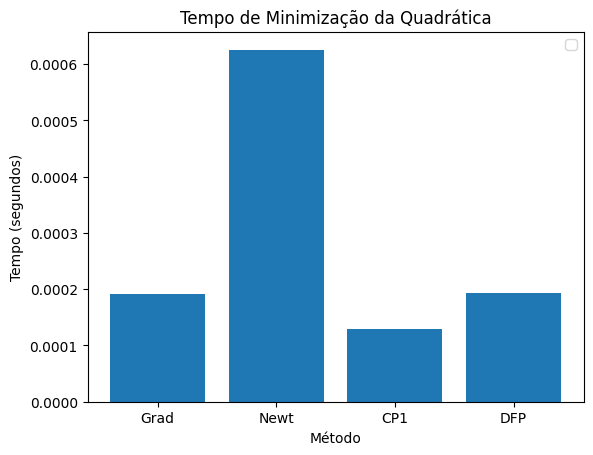

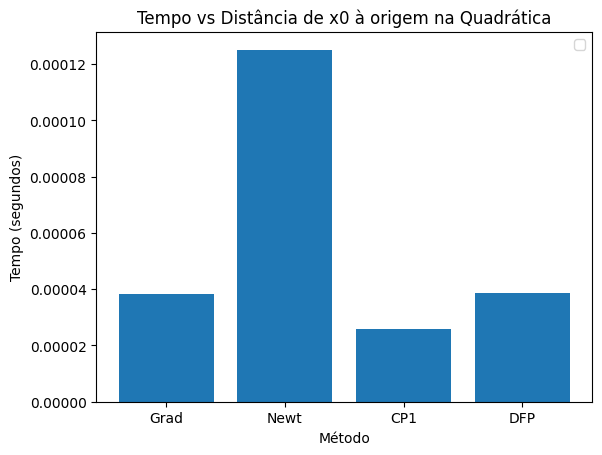

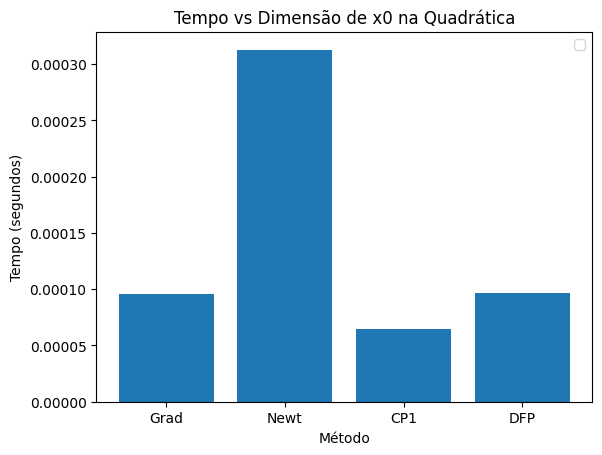

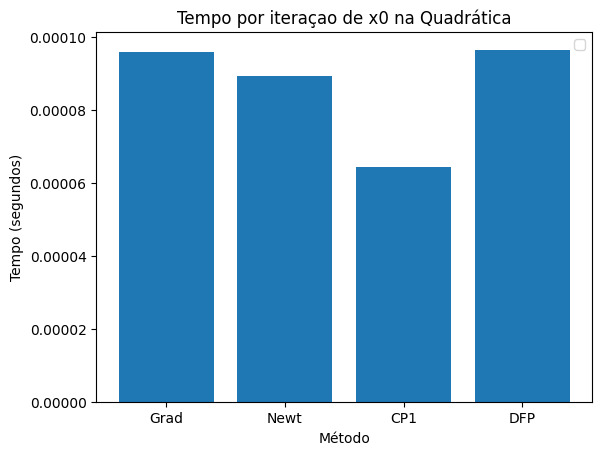

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  0.1


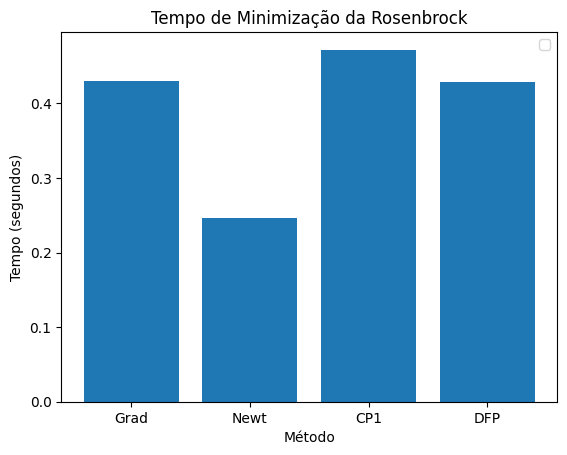

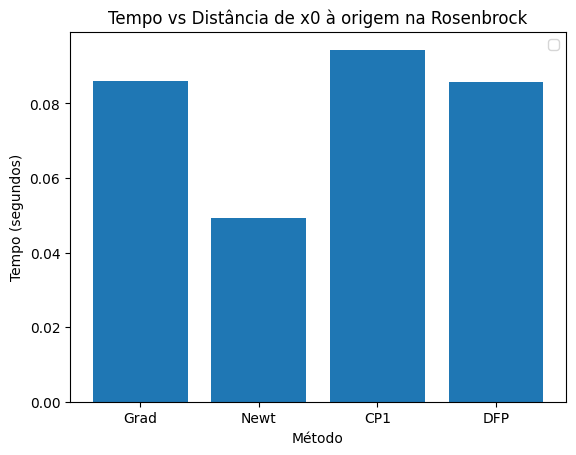

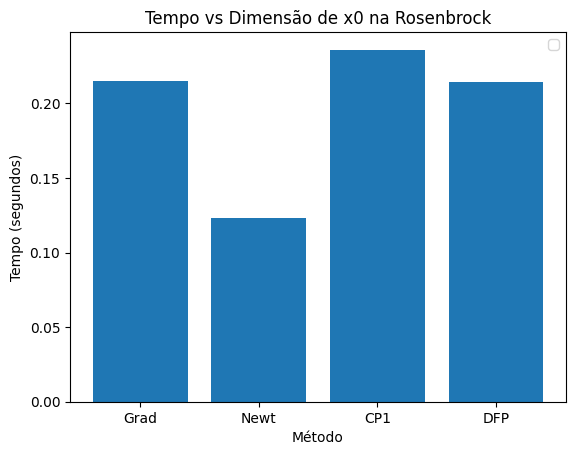

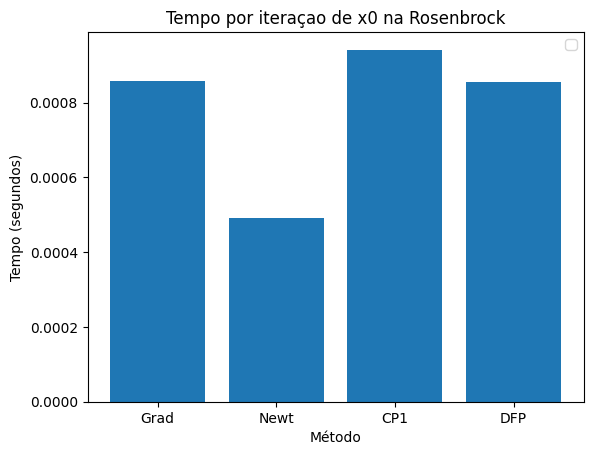

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  0.1


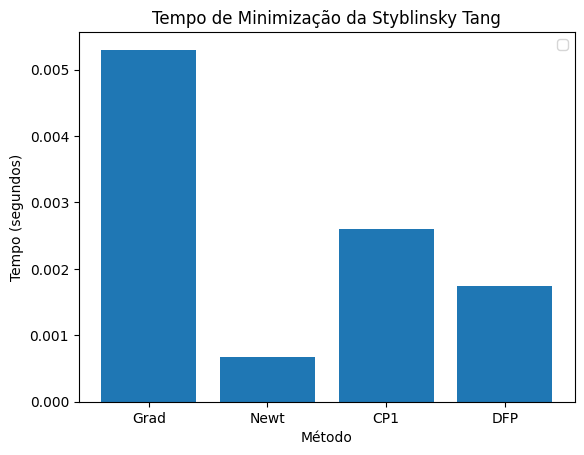

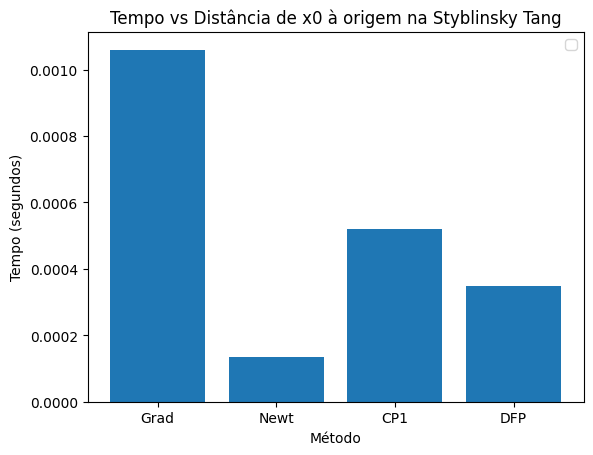

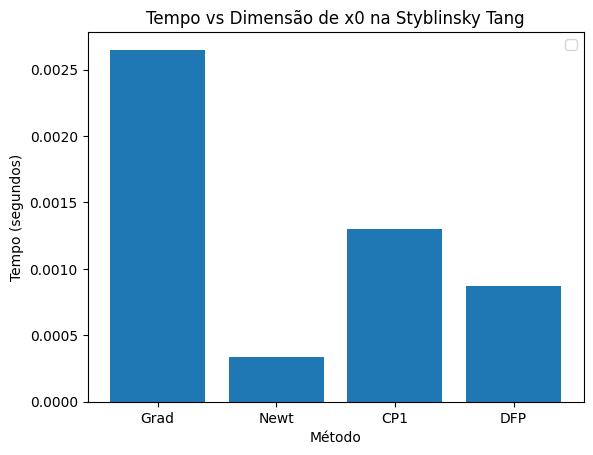

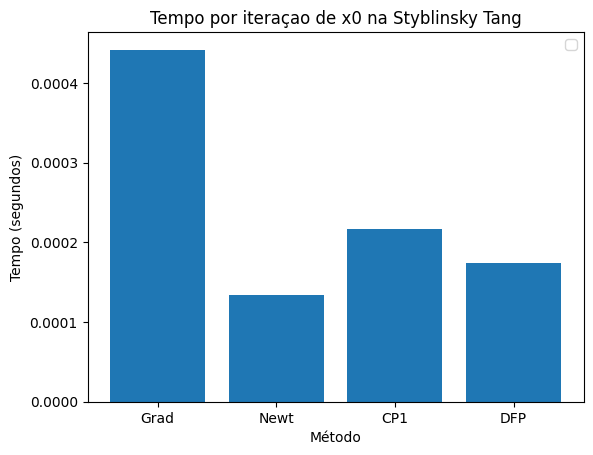

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  0.1


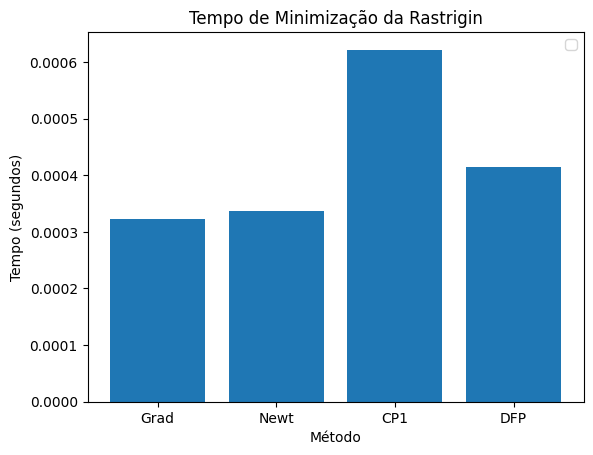

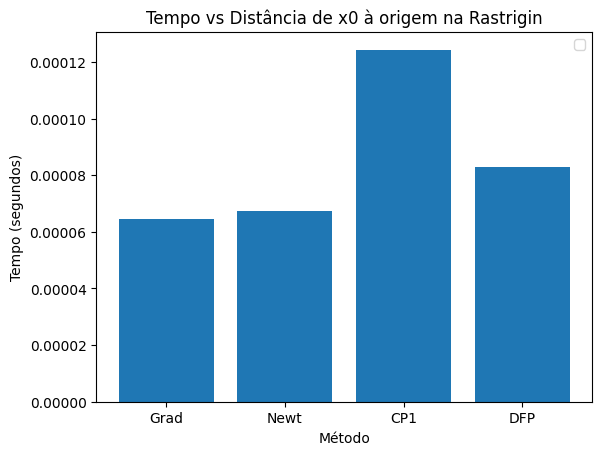

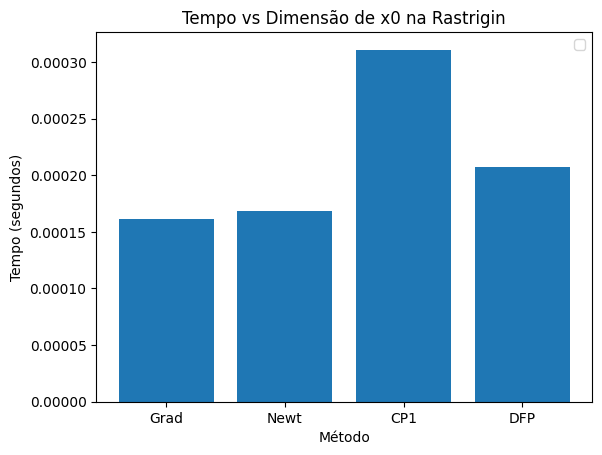

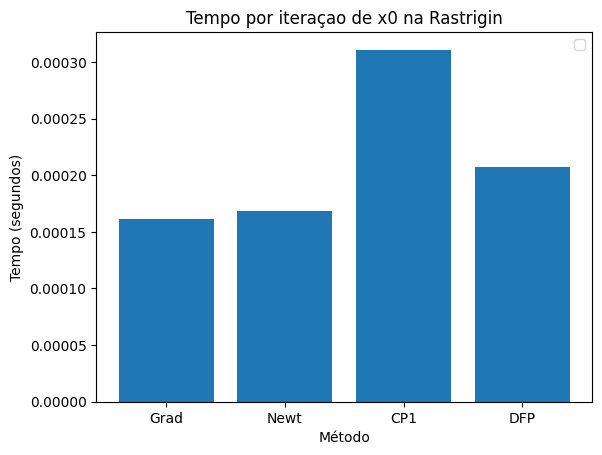

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  1e-12


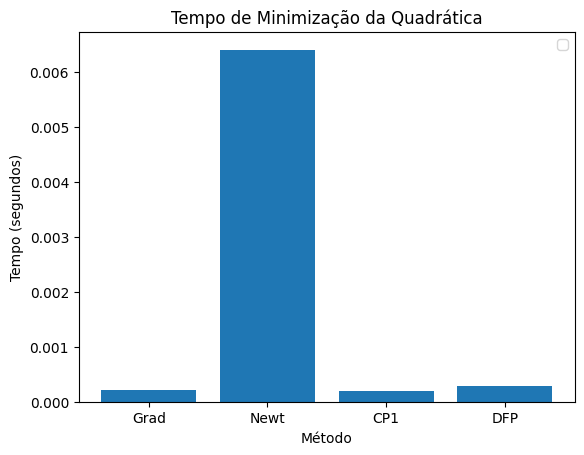

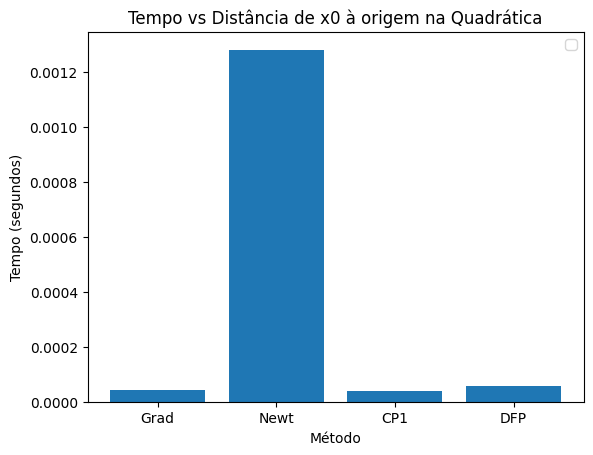

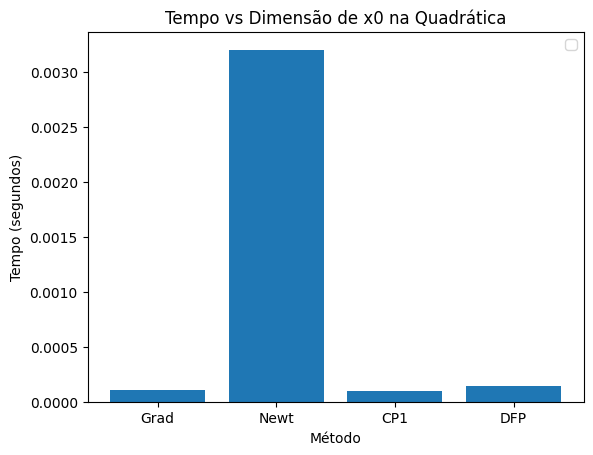

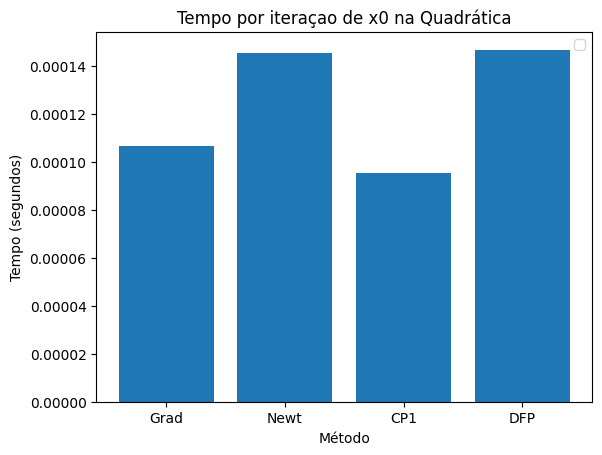

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  1e-12


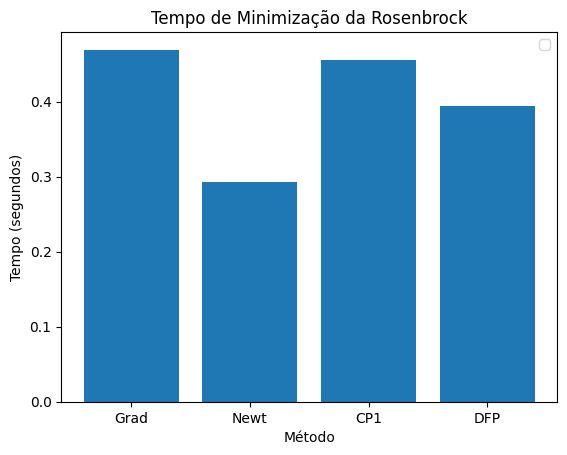

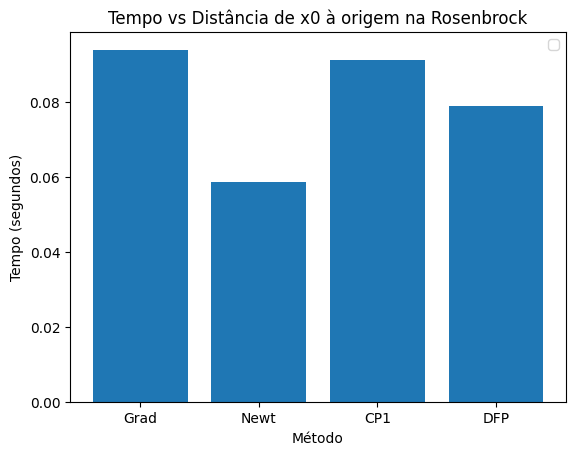

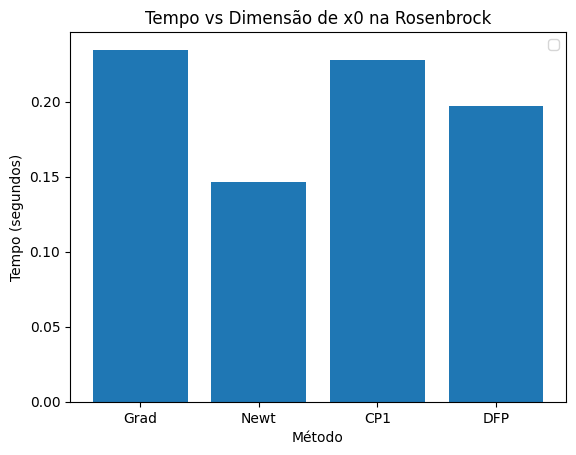

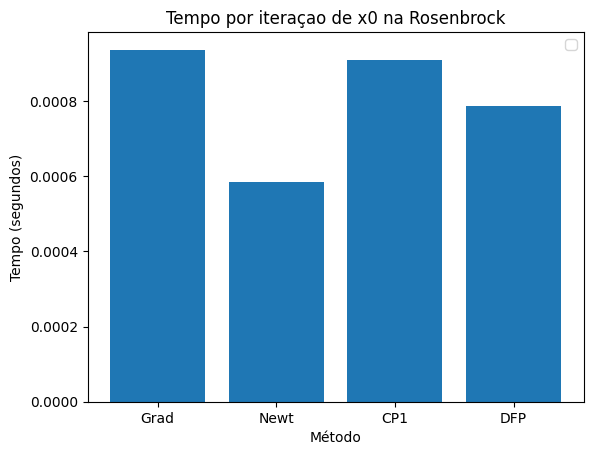

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  1e-12


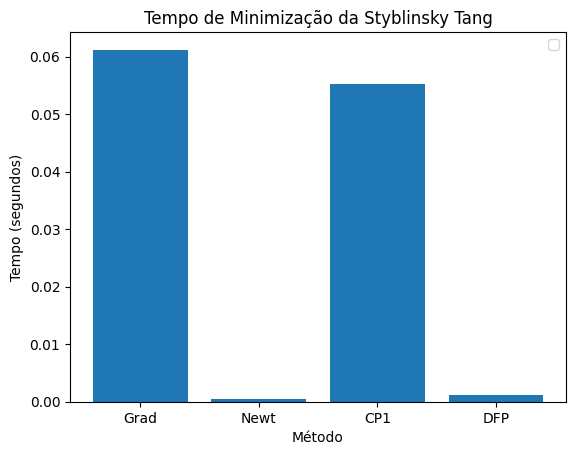

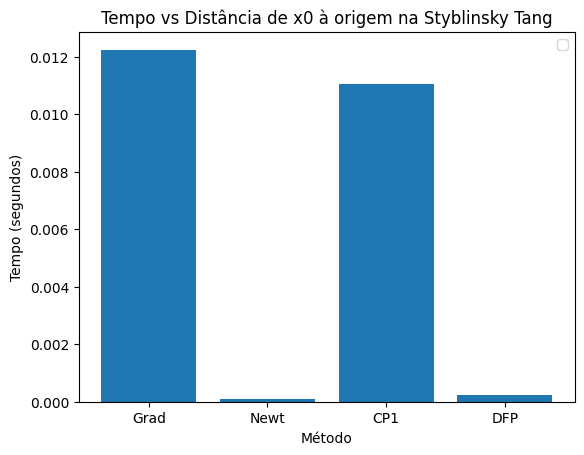

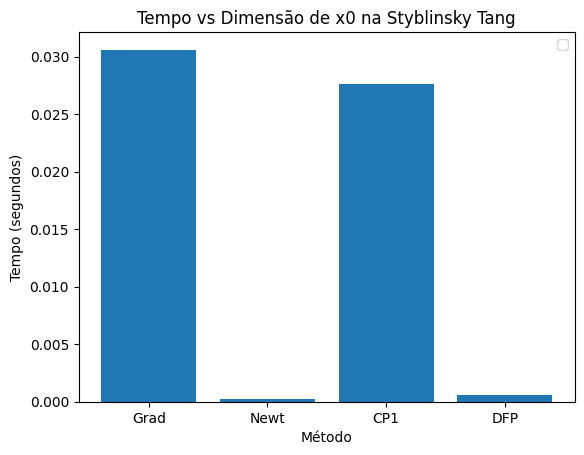

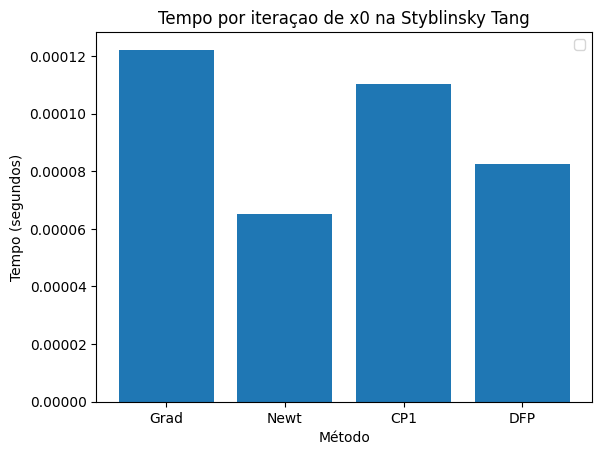

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [4 3] 
 de dimensão 2 distando 5.000 da origem.
epsilon0 =  1e-12


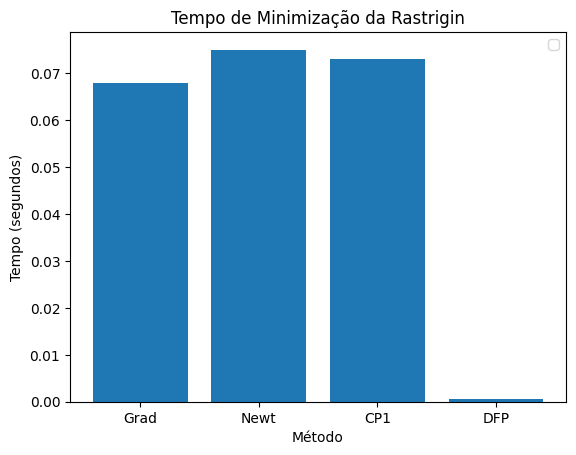

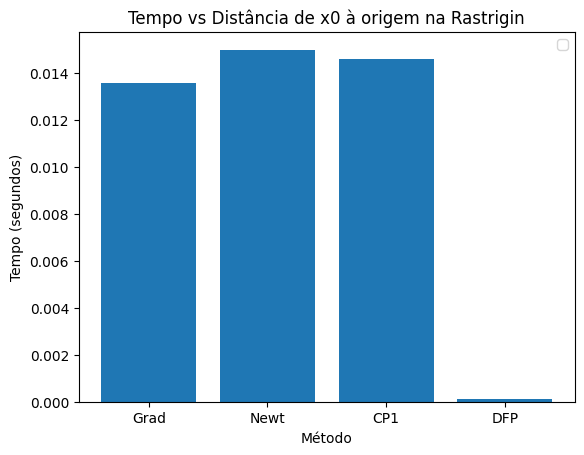

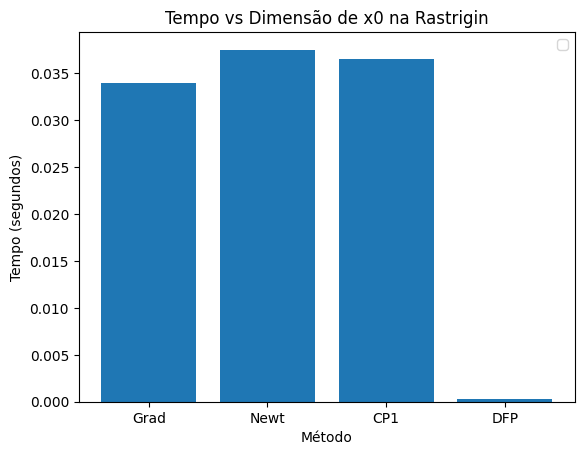

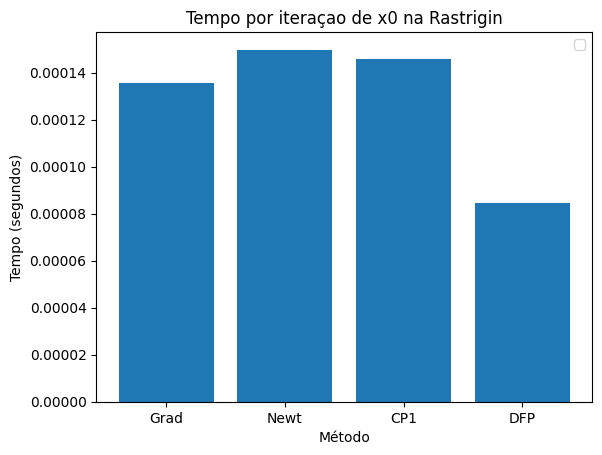

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  0.1


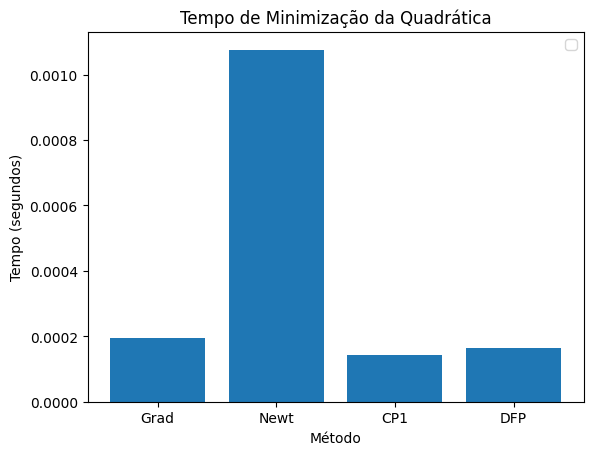

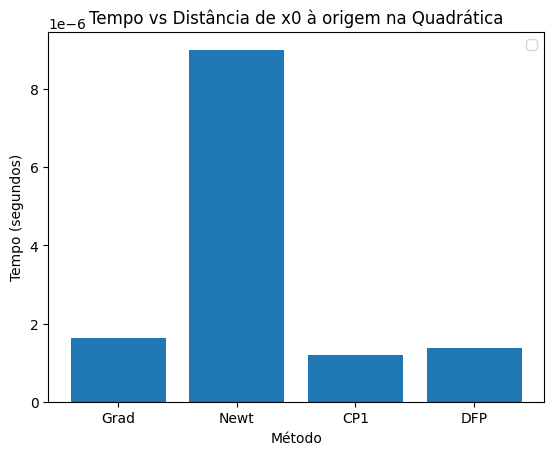

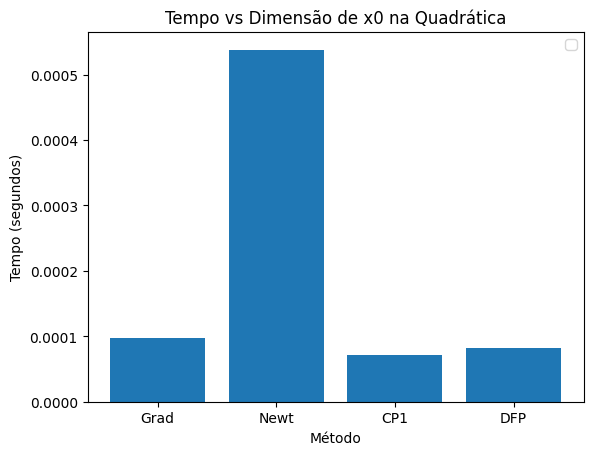

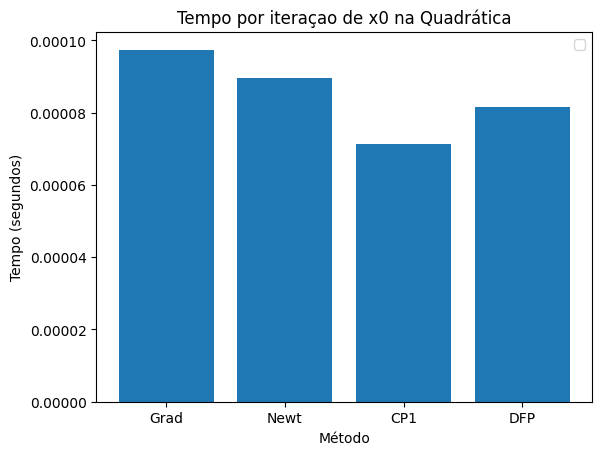

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  0.1


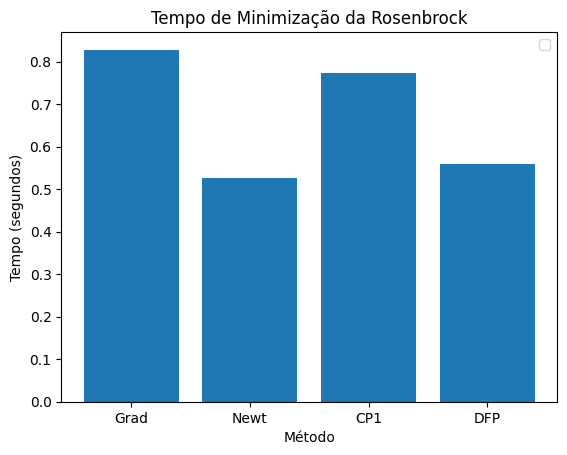

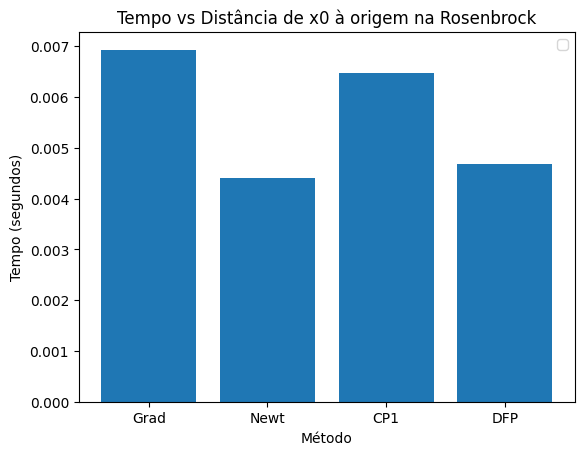

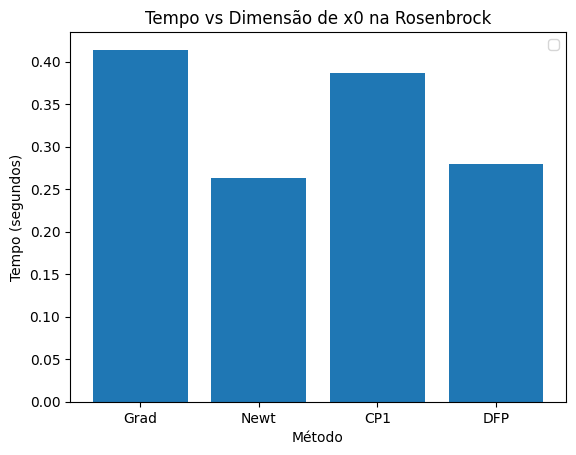

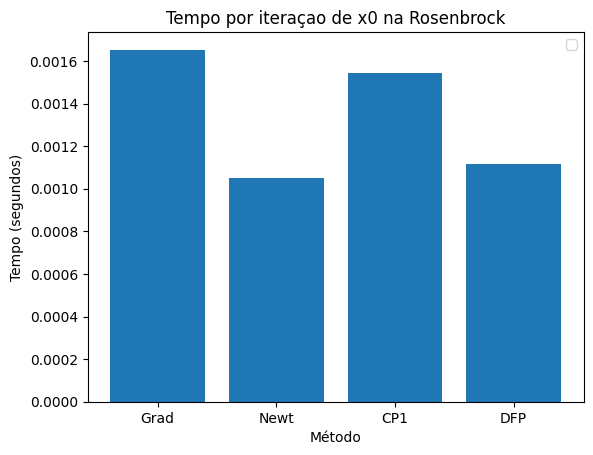

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  0.1


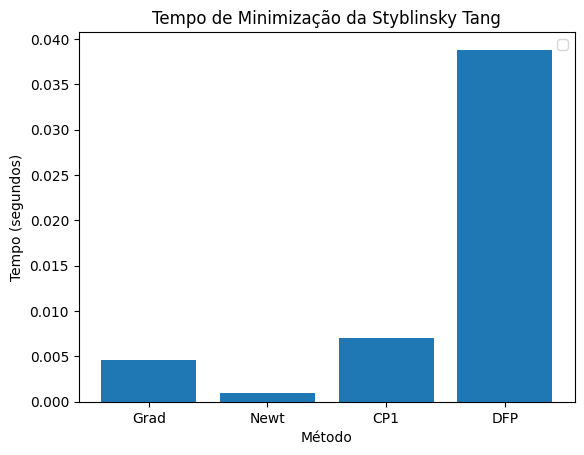

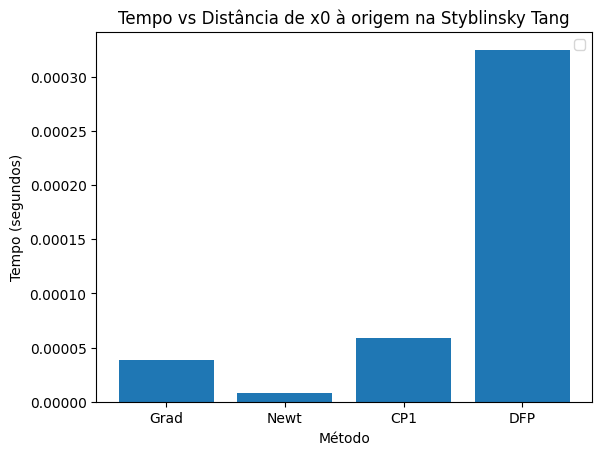

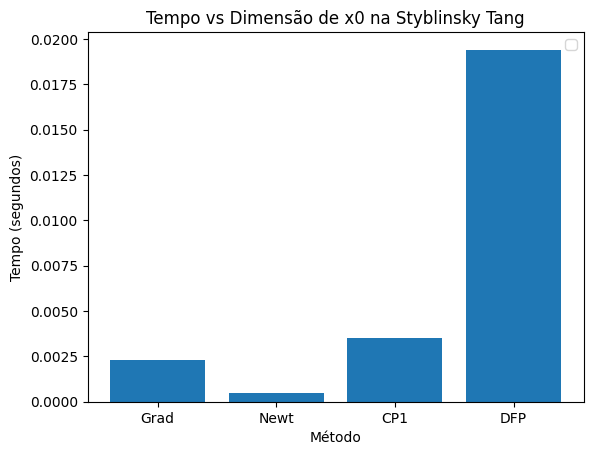

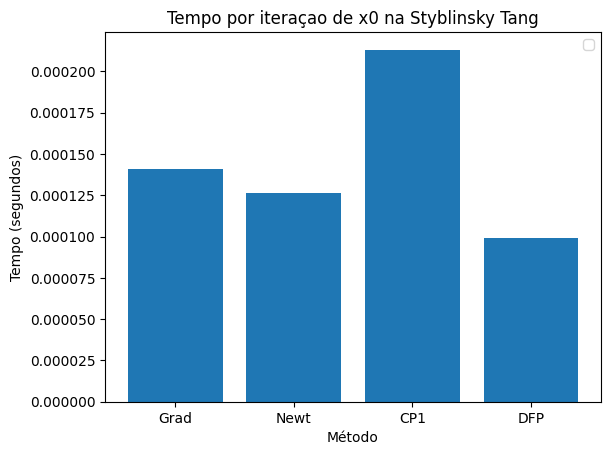

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  0.1


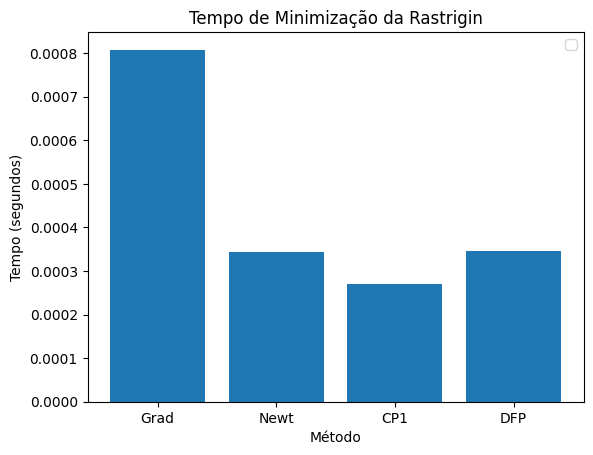

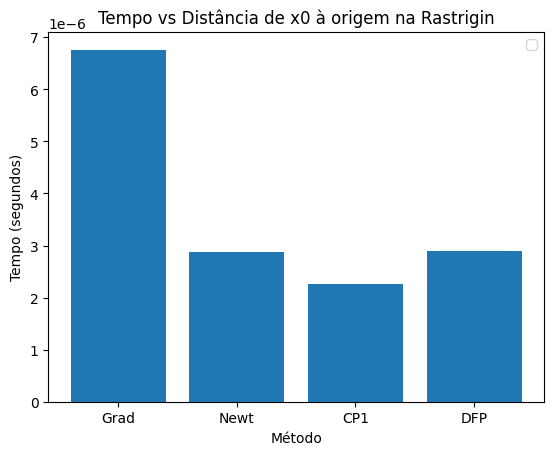

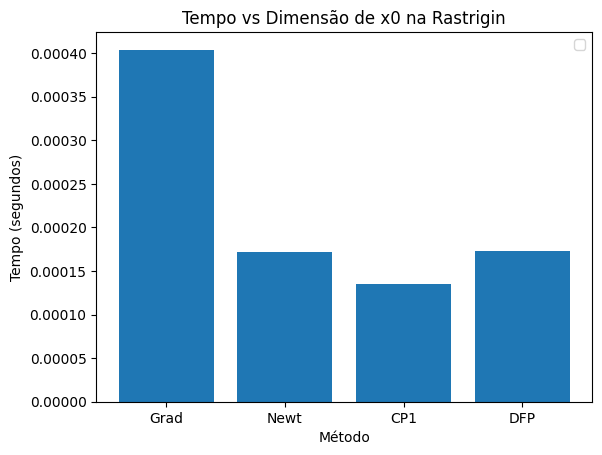

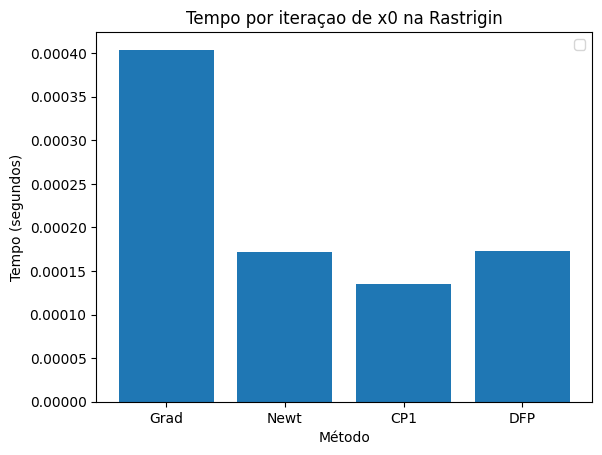

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  1e-12


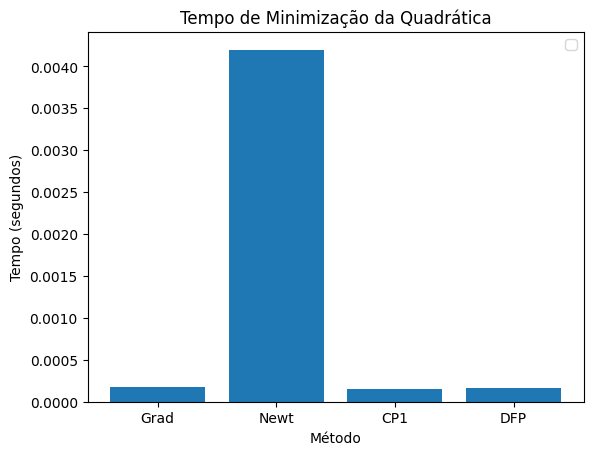

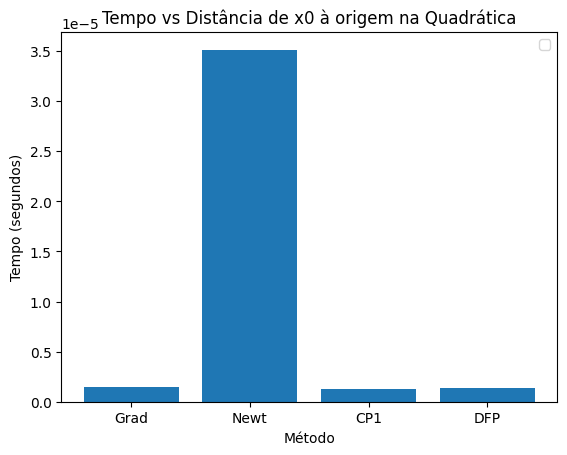

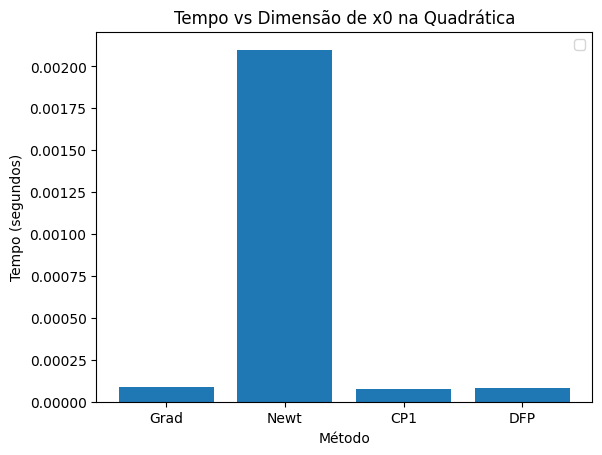

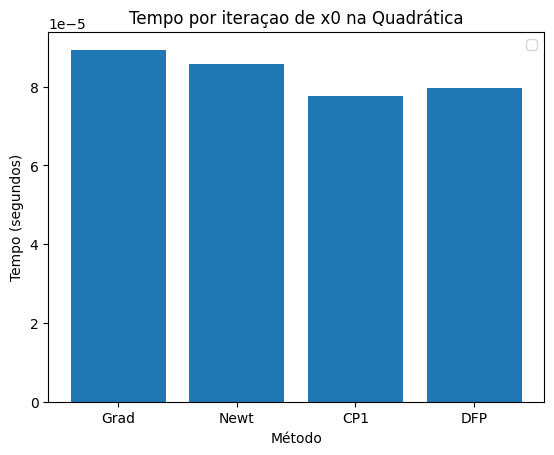

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  1e-12


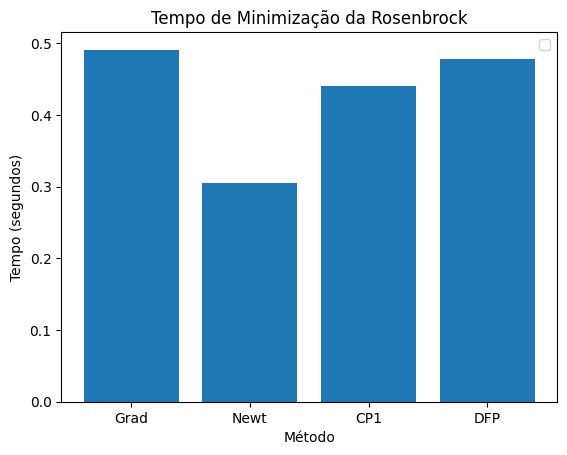

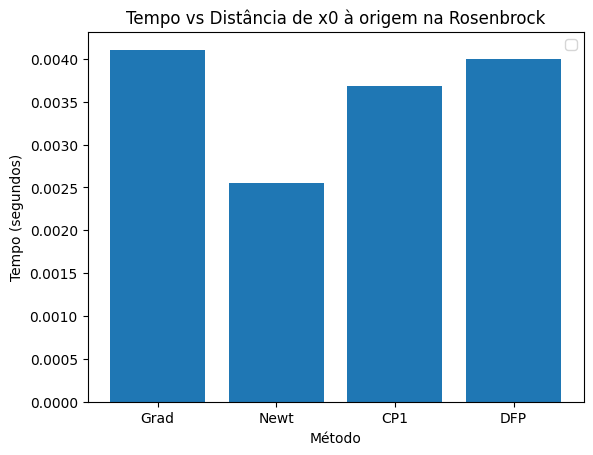

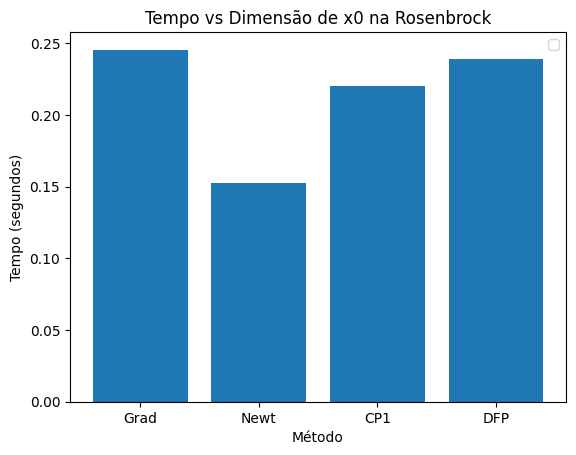

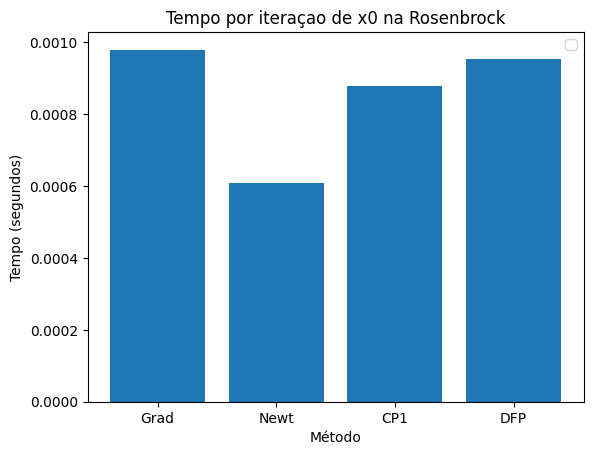

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  1e-12


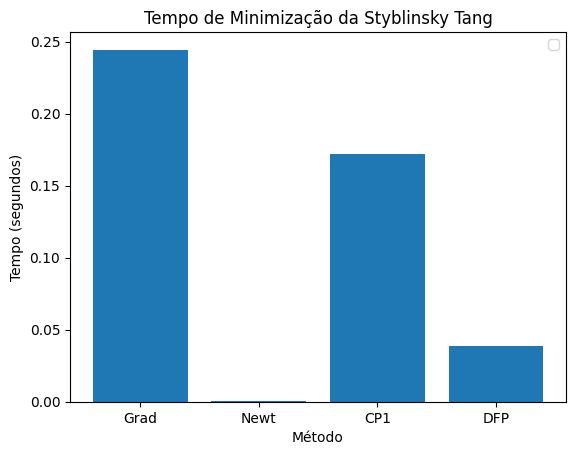

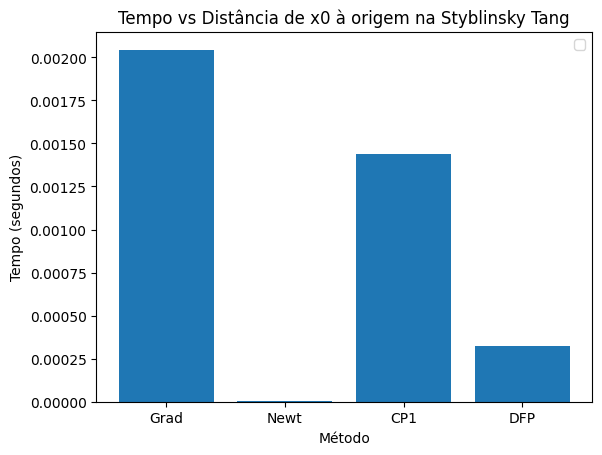

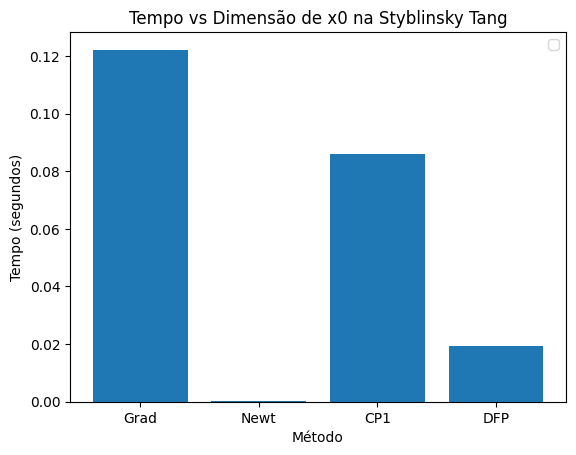

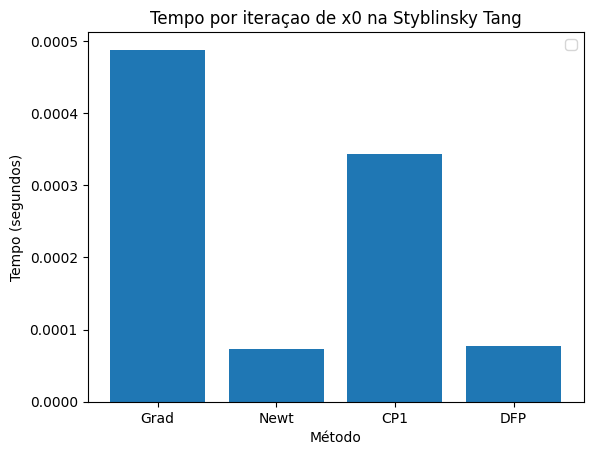

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [86 83] 
 de dimensão 2 distando 119.520 da origem.
epsilon0 =  1e-12


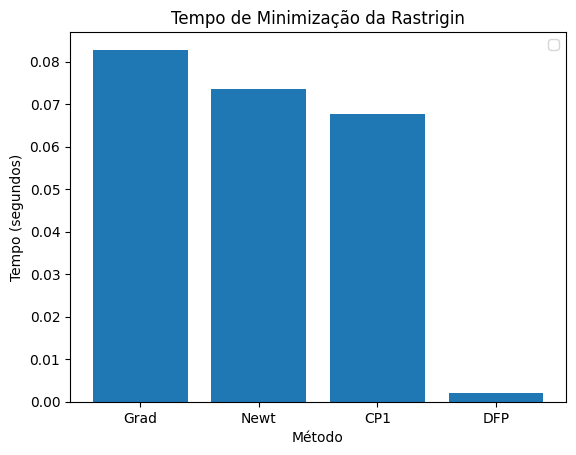

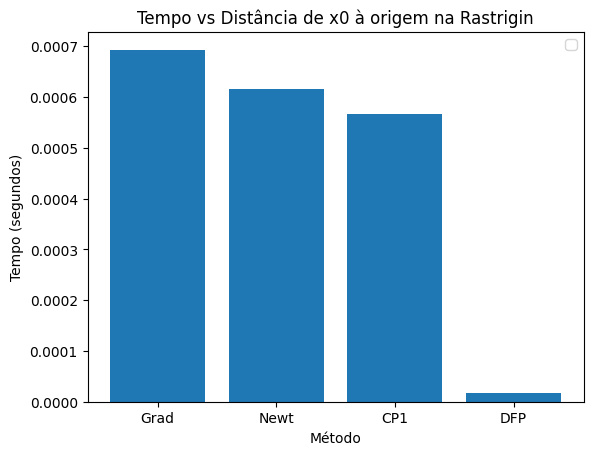

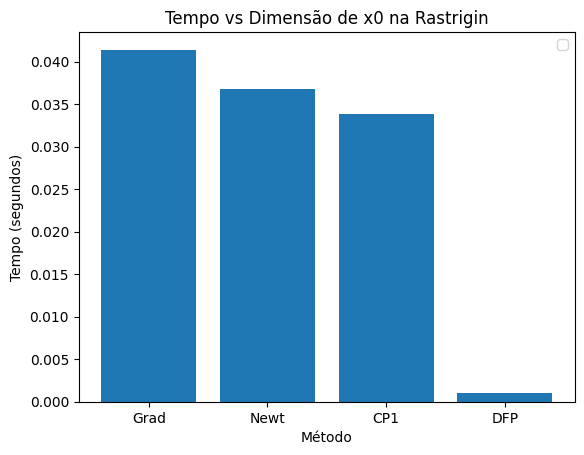

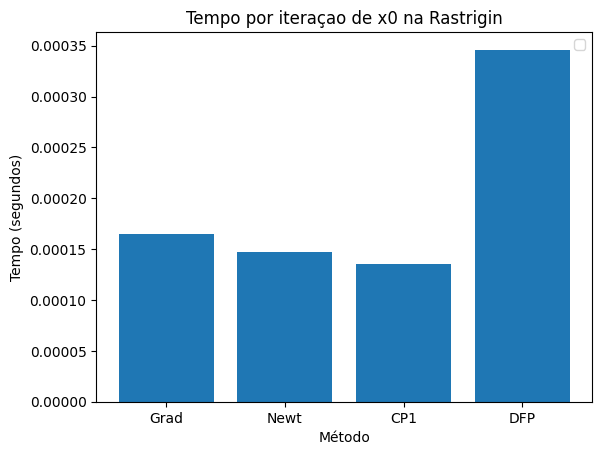

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  0.1


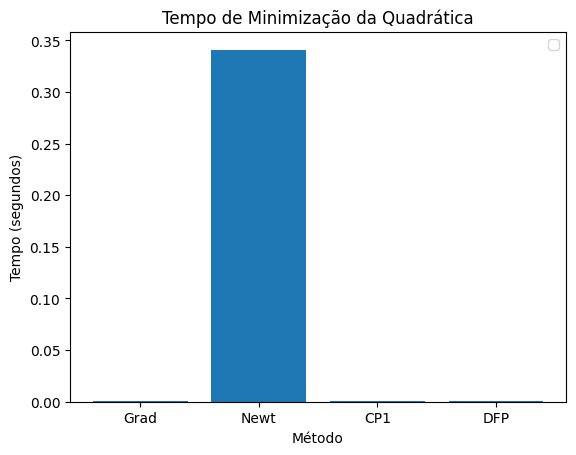

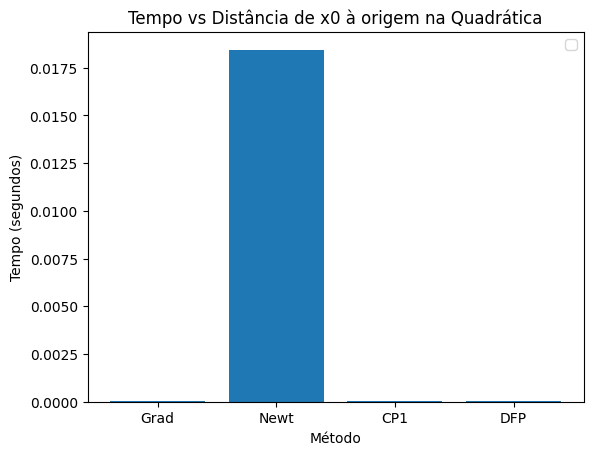

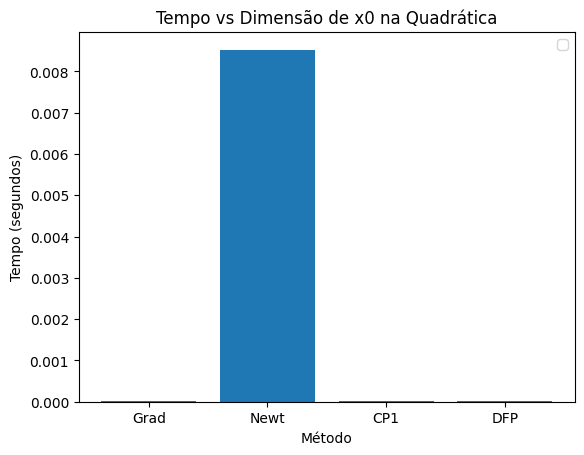

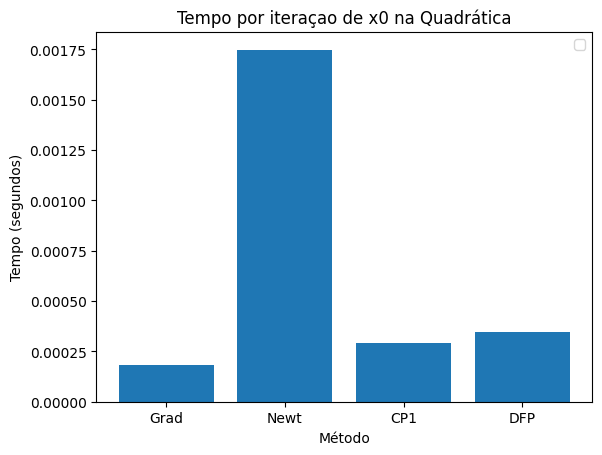

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  0.1


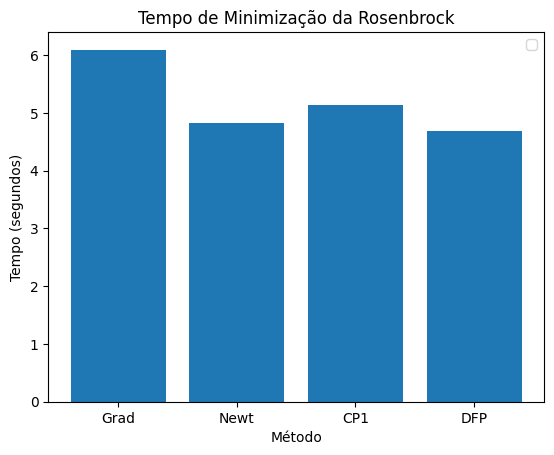

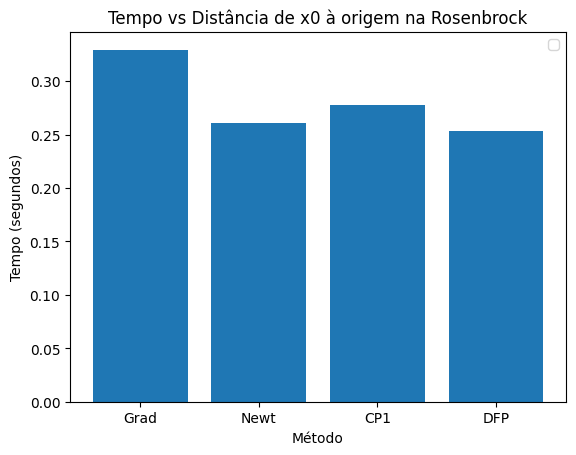

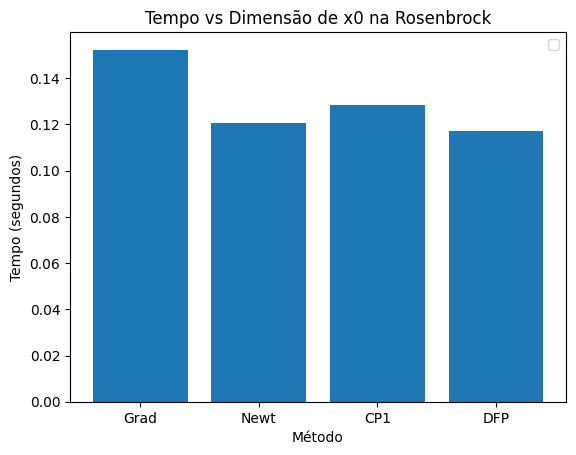

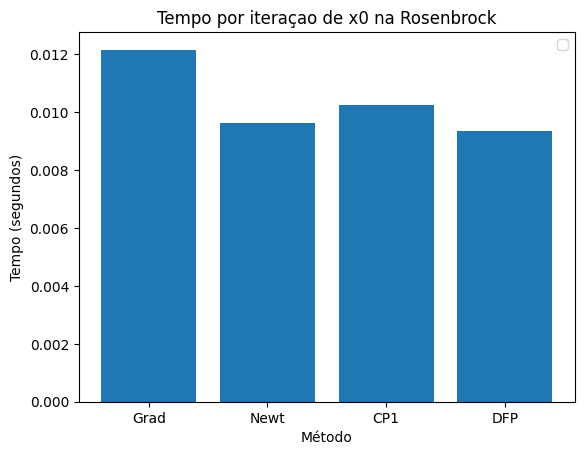

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  0.1


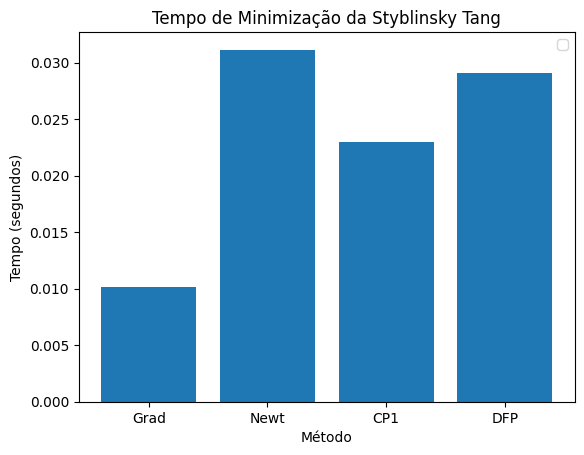

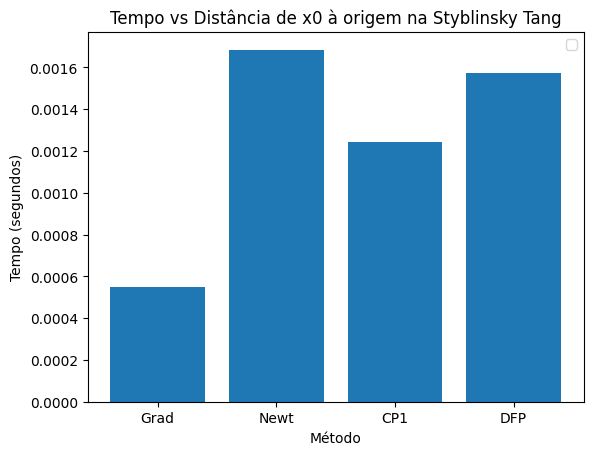

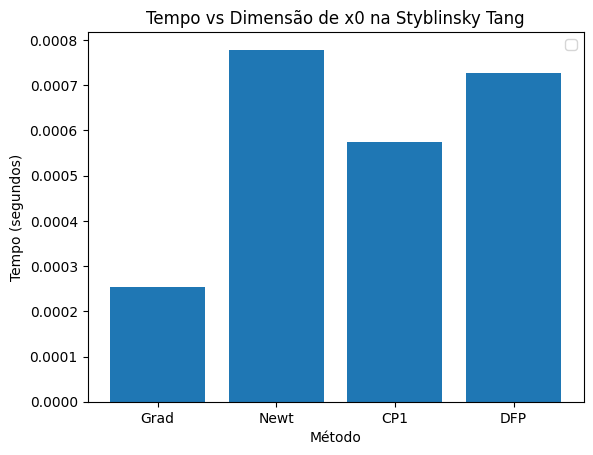

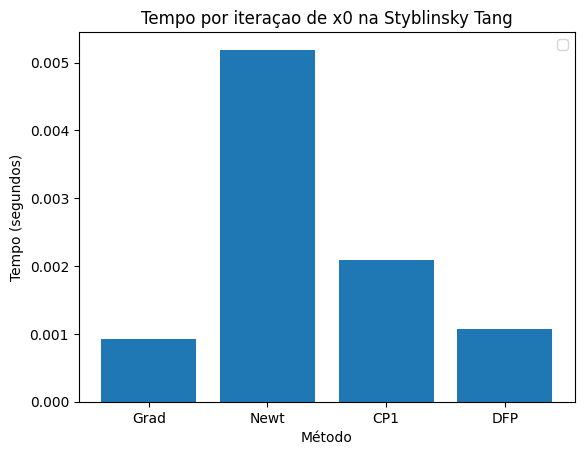

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  0.1


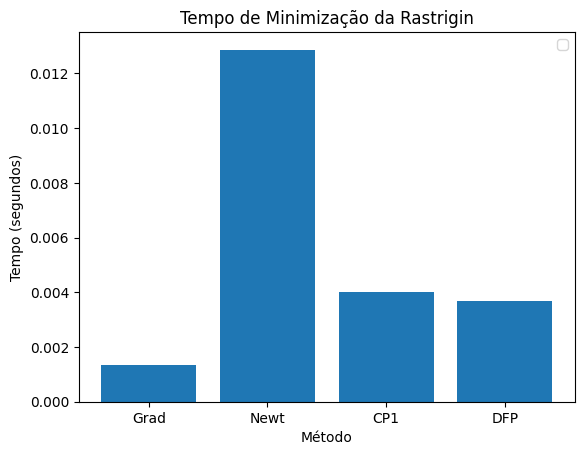

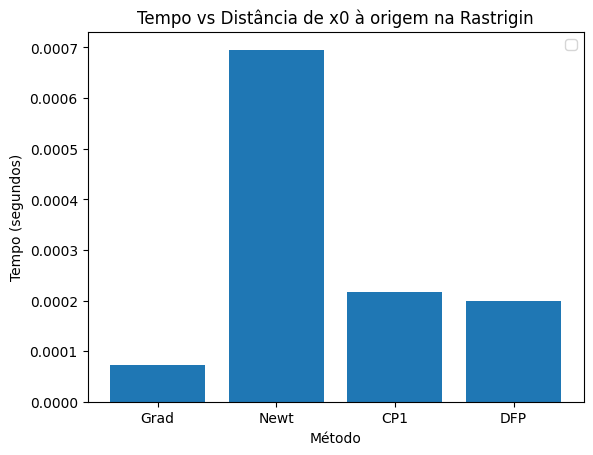

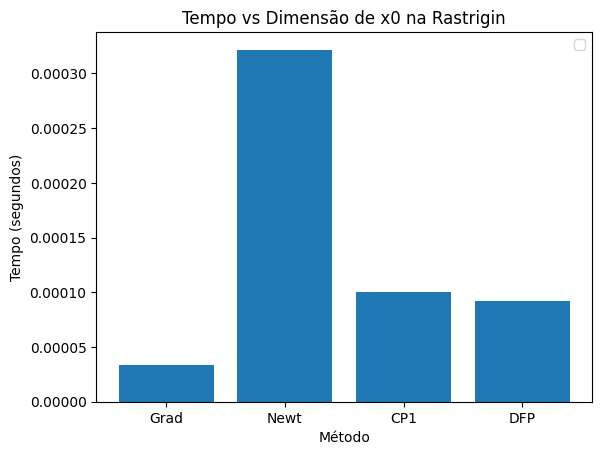

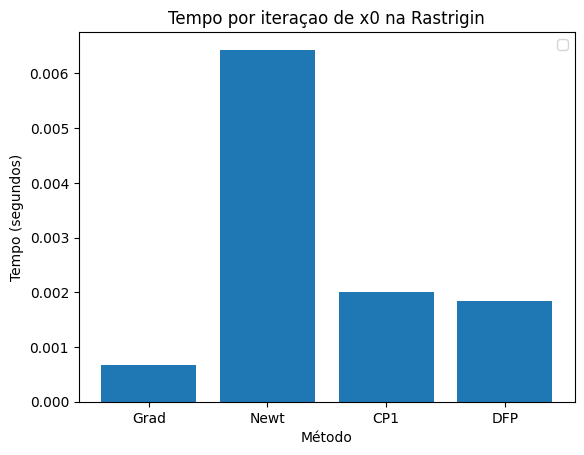

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  1e-12


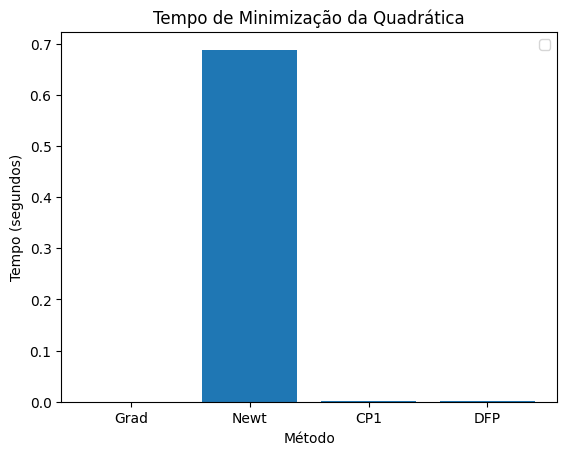

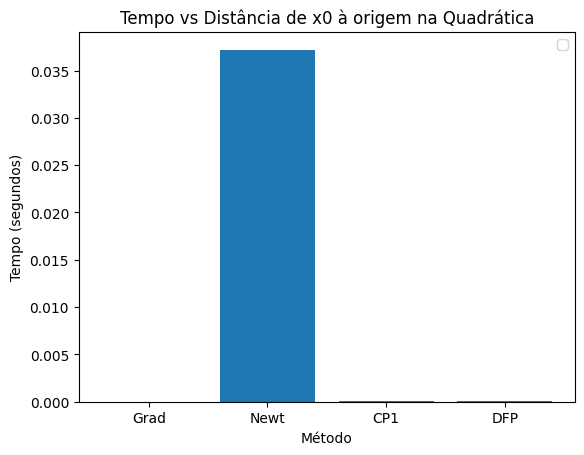

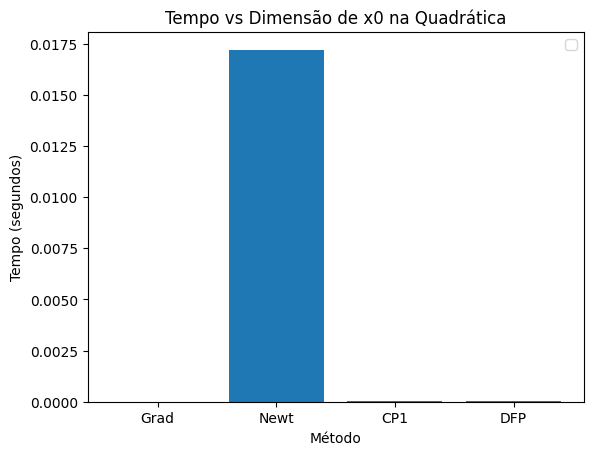

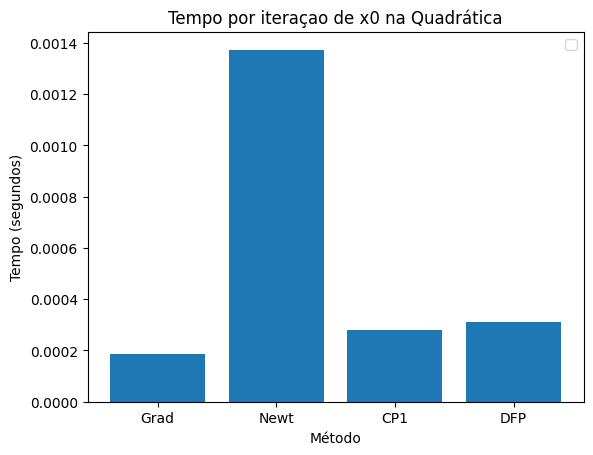

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  1e-12


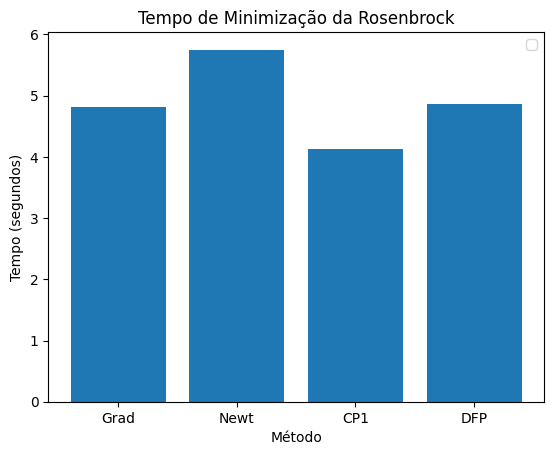

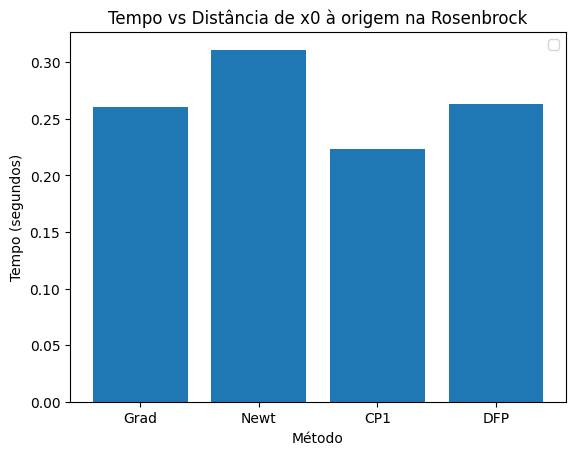

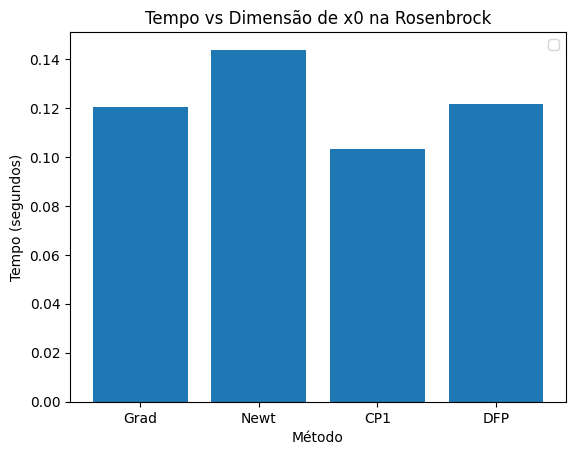

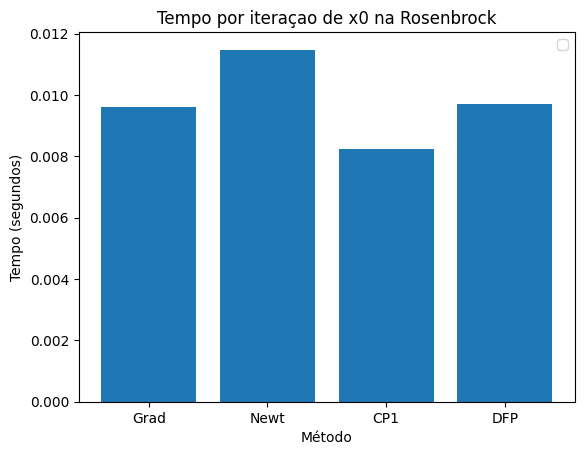

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  1e-12


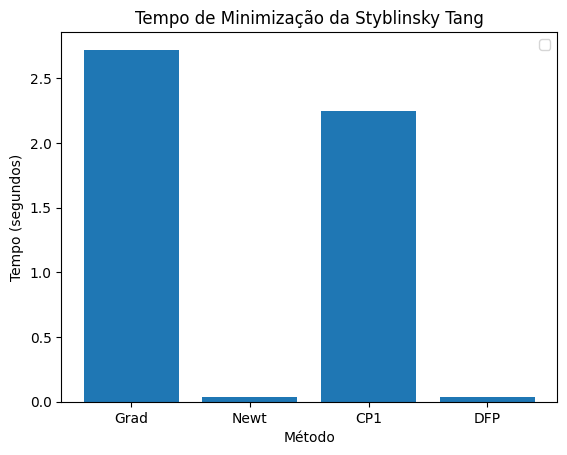

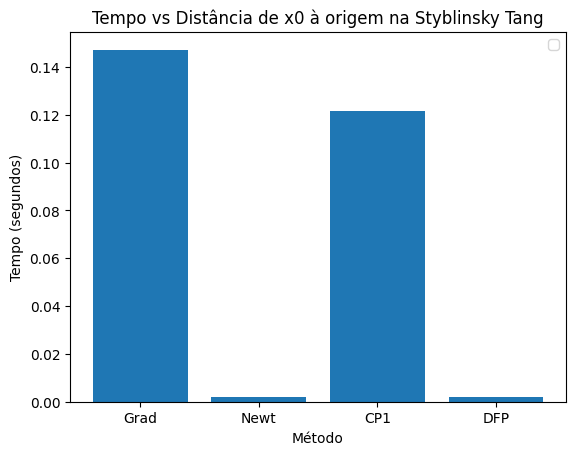

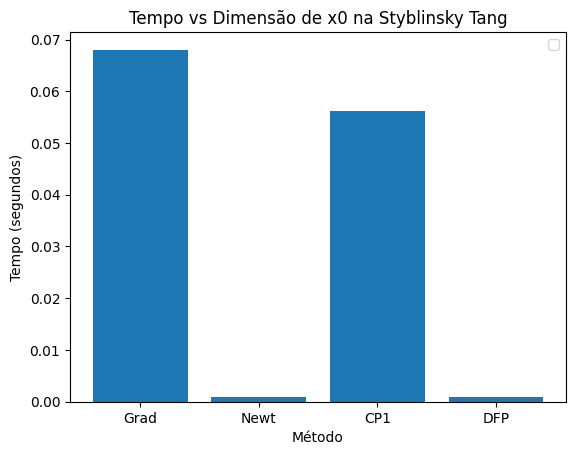

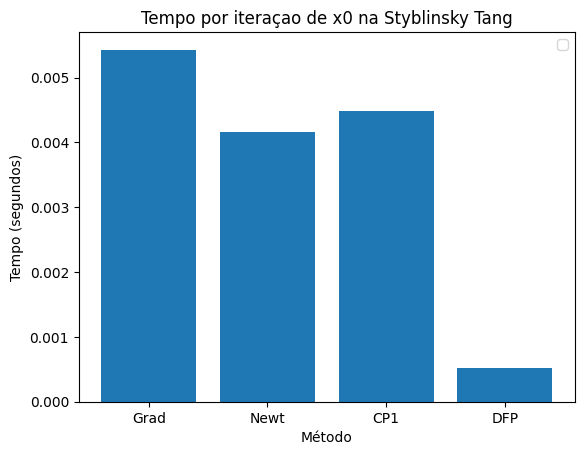

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [2 2 2 3 2 3 3 2 4 3 4 2 2 2 2 2 3 4 2 4 2 4 2 2 4 2 2 2 3 3 4 3 4 3 2 3 4
 4 2 4] 
 de dimensão 40 distando 18.493 da origem.
epsilon0 =  1e-12


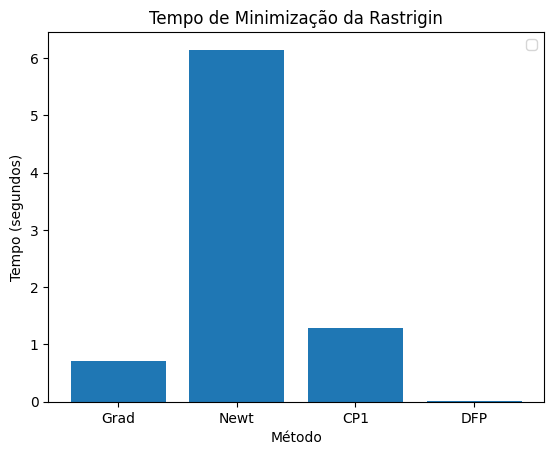

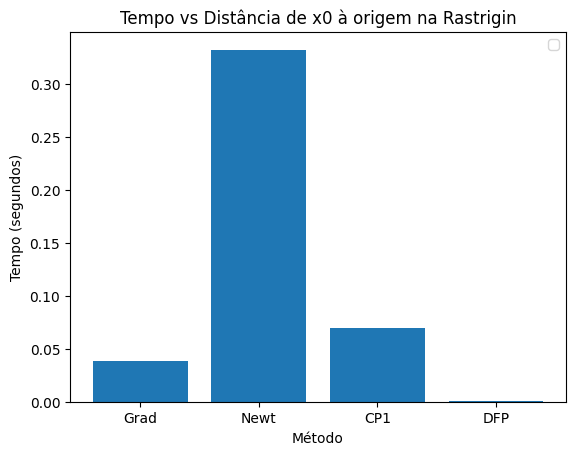

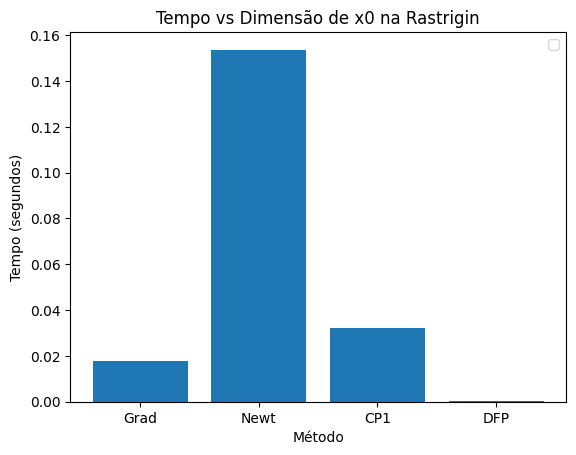

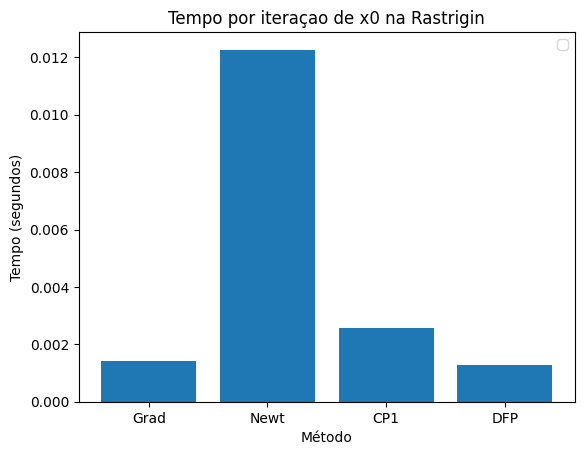

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  0.1


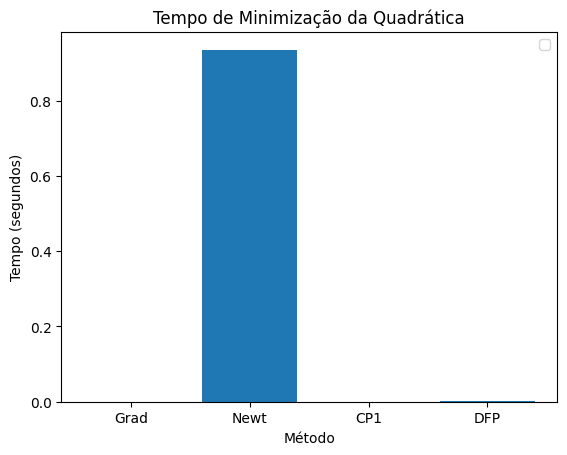

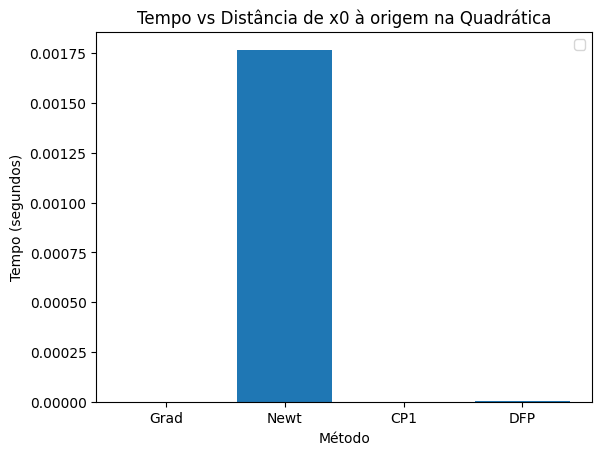

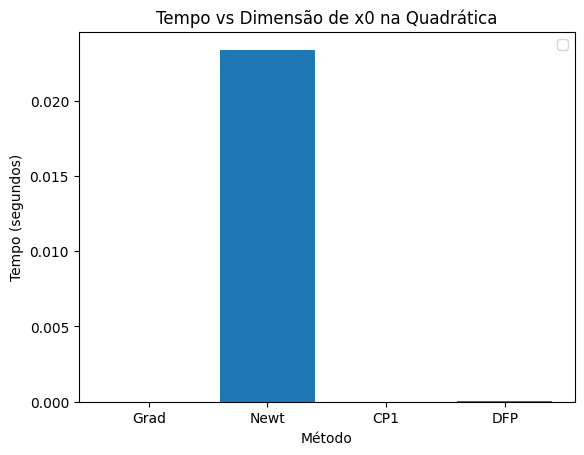

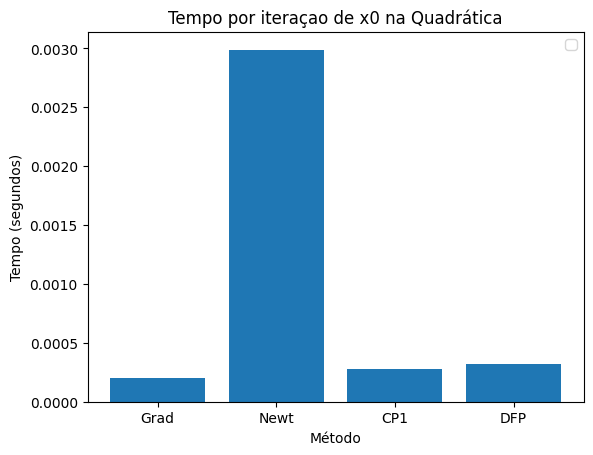

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  0.1


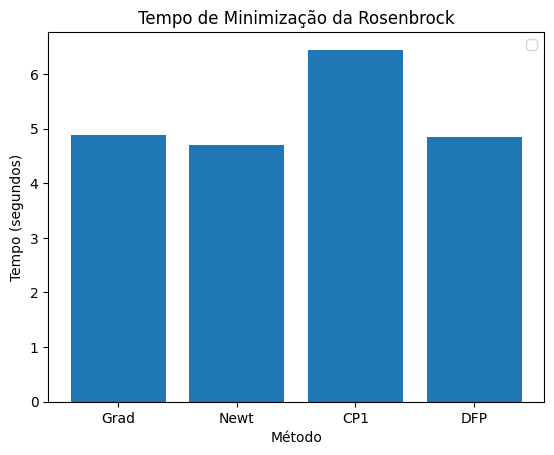

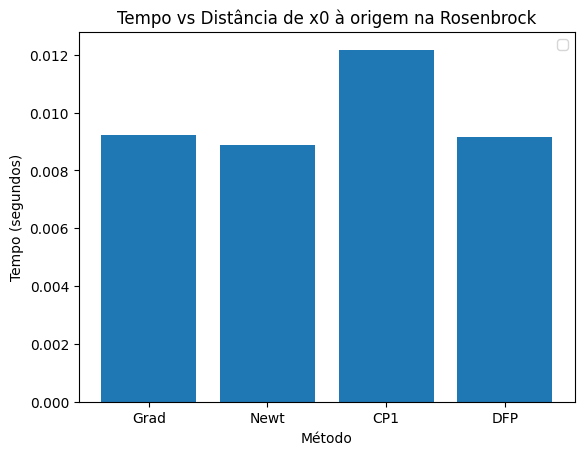

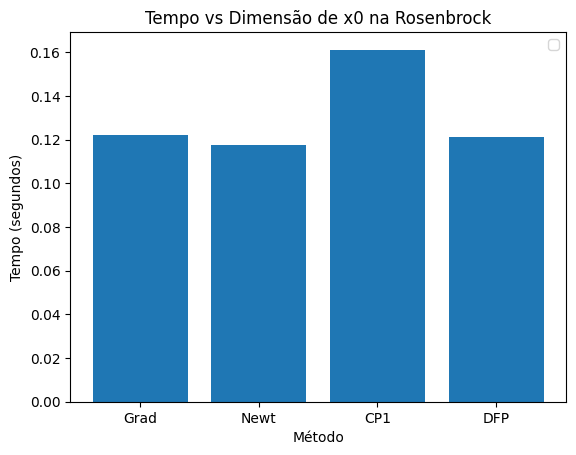

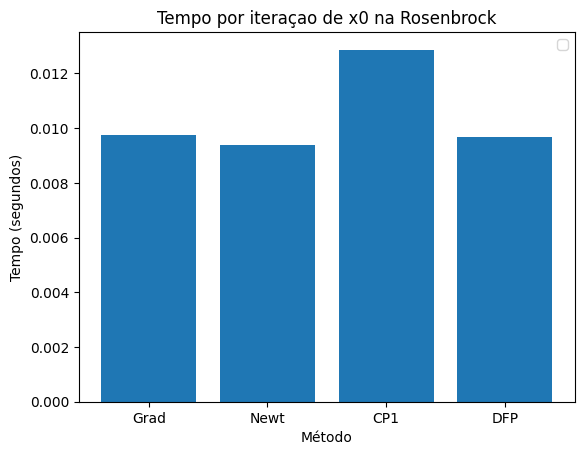

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  0.1


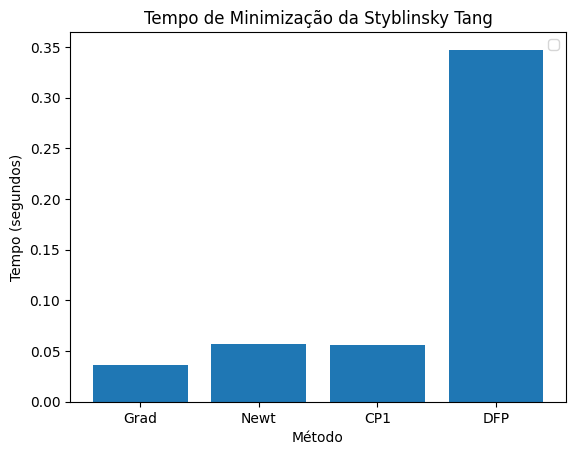

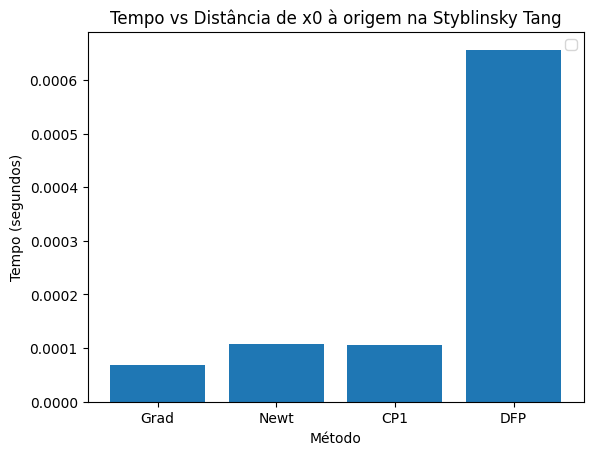

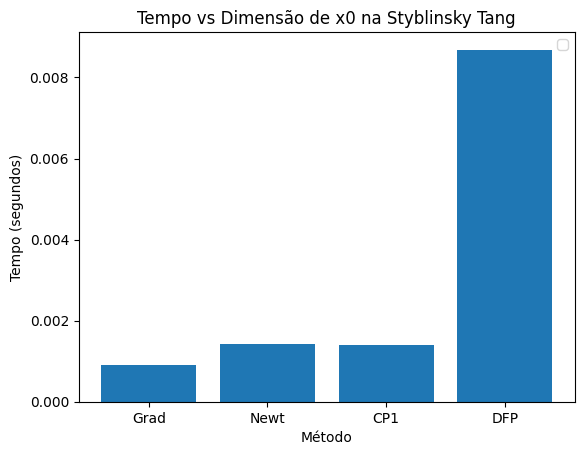

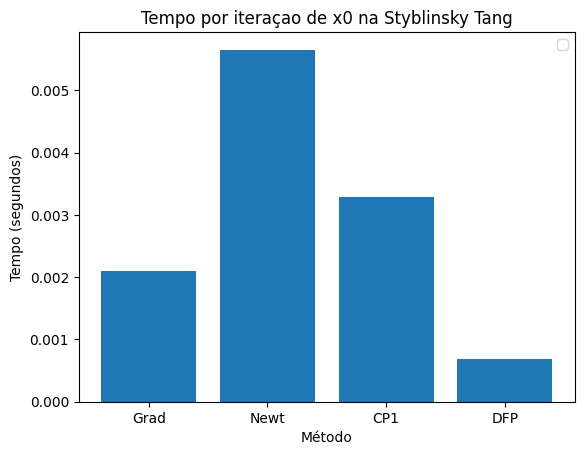

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  0.1


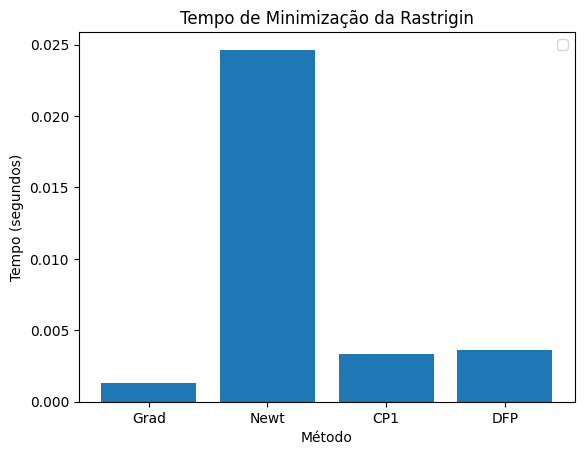

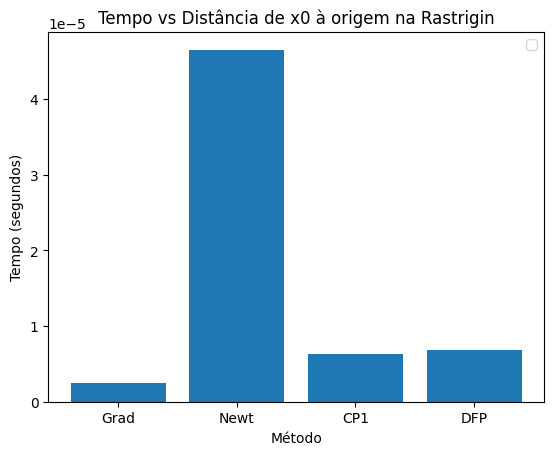

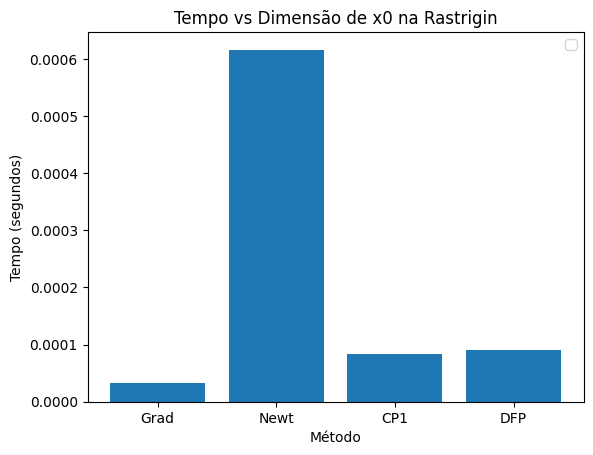

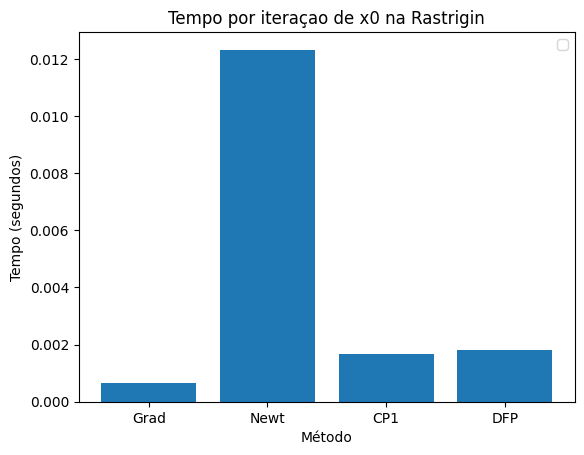

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Quadrática
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  1e-12


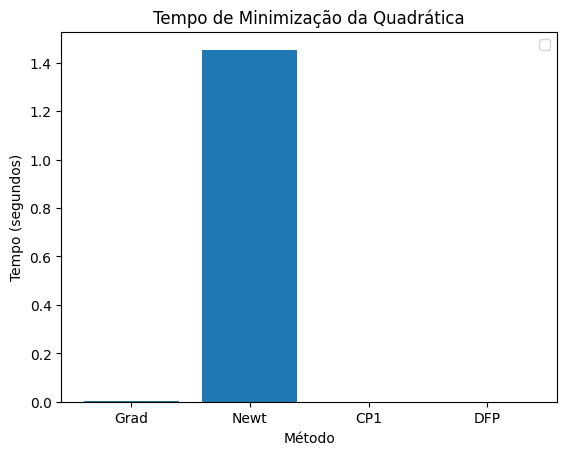

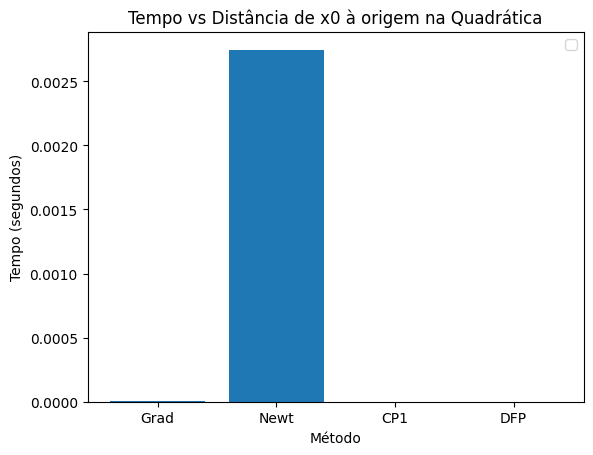

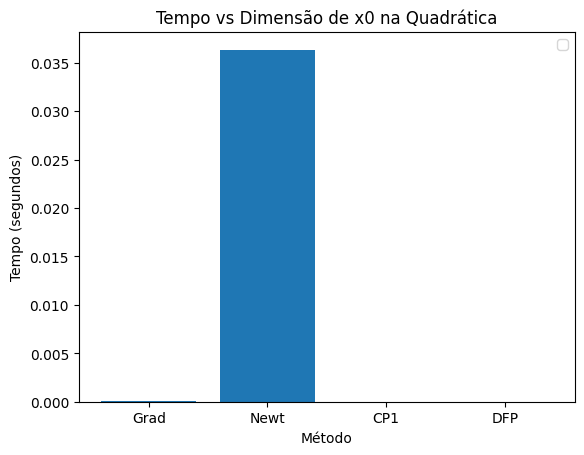

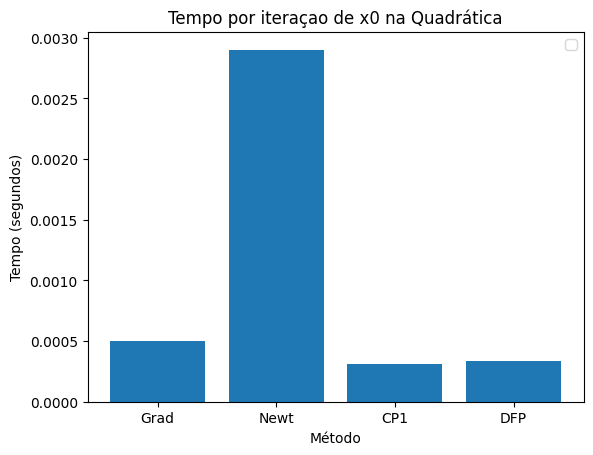

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rosenbrock
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  1e-12


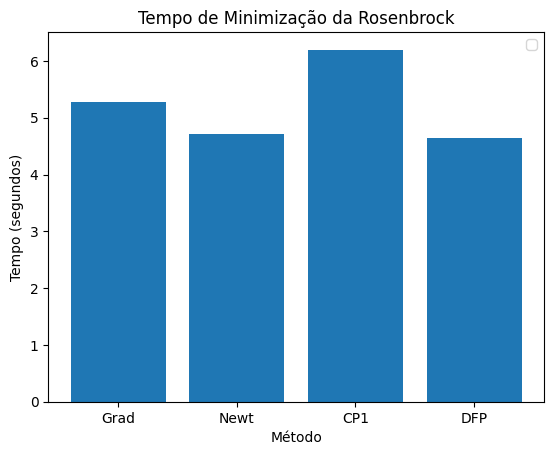

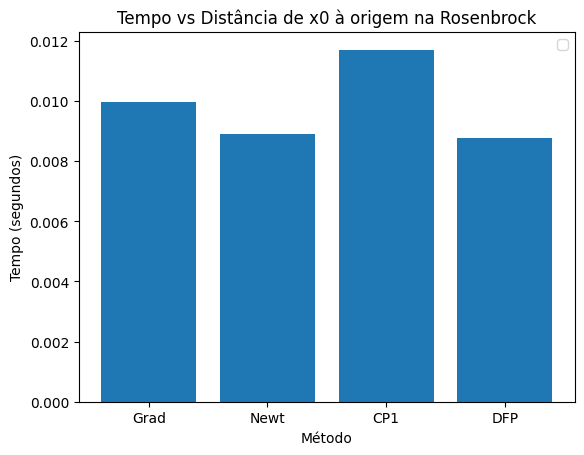

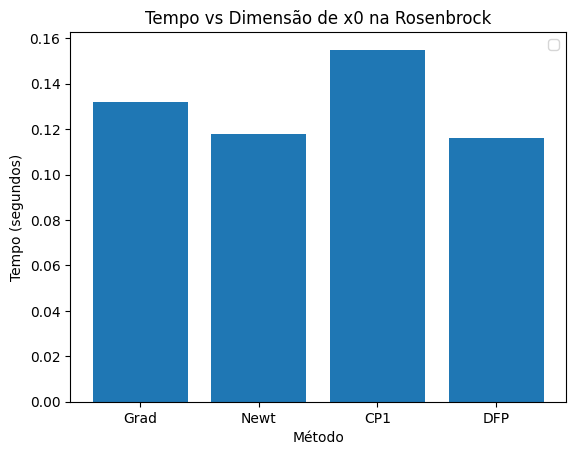

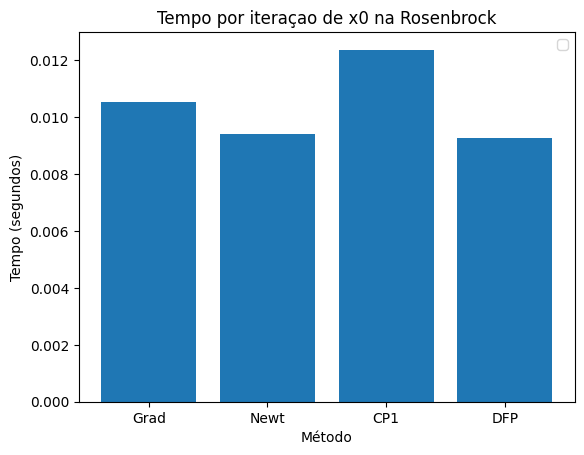

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Styblinsky Tang
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  1e-12


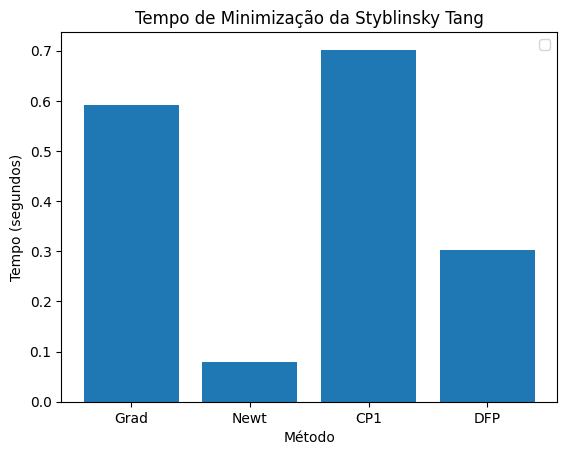

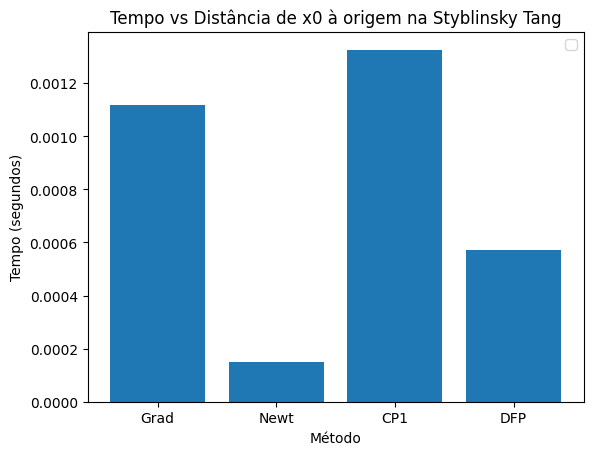

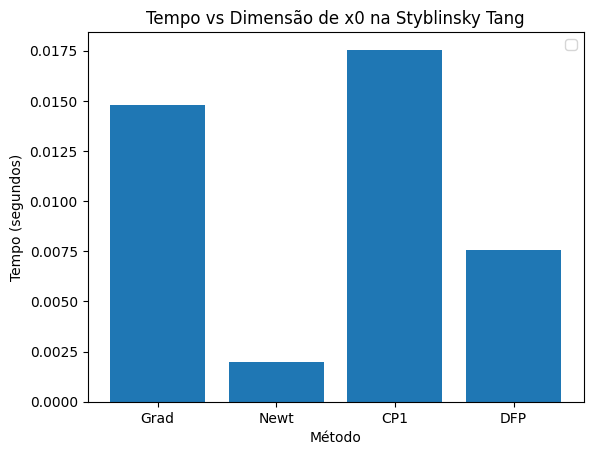

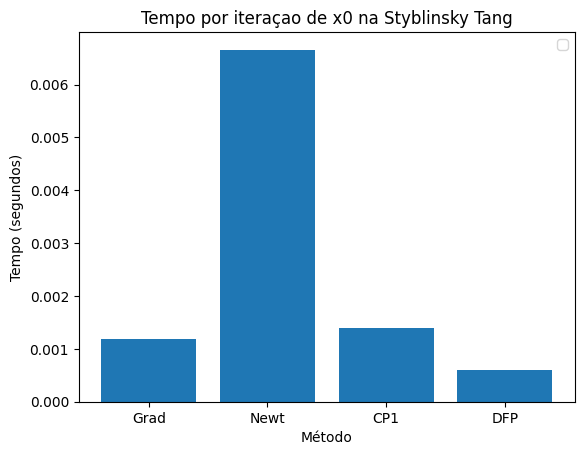

Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função Rastrigin
Usando os valores: 

x0 =  [95 77 78 79 98 99 78 78 88 90 76 79 87 75 82 93 94 81 88 97 80 79 80 76
 94 82 76 97 76 84 78 83 83 76 75 83 78 85 81 77] 
 de dimensão 40 distando 529.316 da origem.
epsilon0 =  1e-12


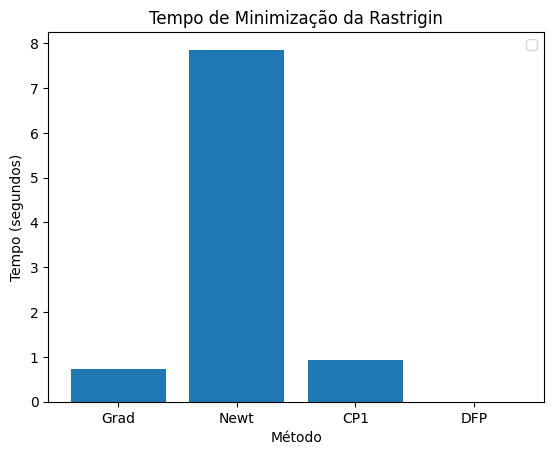

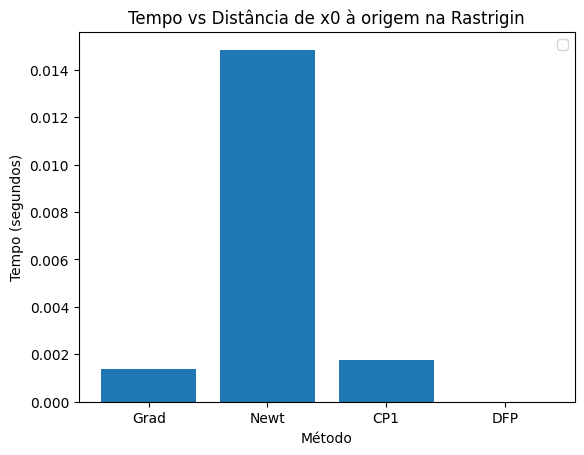

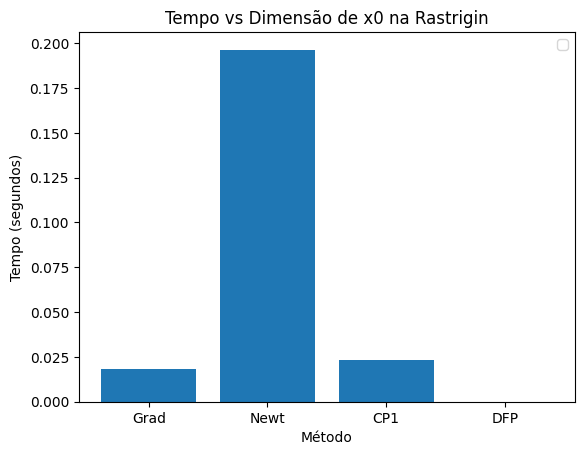

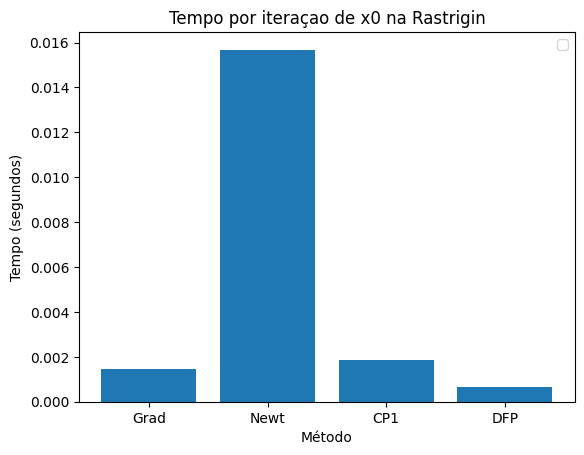

In [ ]:
# Define os valores para x0 baseados nos criterios de distincao:

Dimensoes = [2, 40]

# Como os pontos ótimos das 4 funções implementadas são próximos do zero,
# a distância será variada em relação à origem.

x0_valores = []

for dim in Dimensoes:
  x0_valores.append(np.random.randint(low = 2, high = 5, size = dim))
  x0_valores.append(np.random.randint(low = 75, high = 100, size = dim))

# Definindo epsilons
epsilon_valores = [1e-1, 1e-12]

# Definindo vetor contendo tipos de Funções
Funcao_tipo = [quadratica, rosenbrock, styblinsky_tang, rastrigin]

# Definindo vetor contendo tipos de Gradientes
grad_tipo = [gradiente_quadratica, gradiente_rosenbrock, gradiente_styblinsky_tang, gradiente_rastrigin]

# Definindo vetor contendo tipos de Hessianas
hessiana_tipo = [hessiana_quadratica, hessiana_rosenbrock, hessiana_styblinsky_tang, hessiana_rastrigin]

# Nomes das Funções
Funcoes = ["Quadrática", "Rosenbrock", "Styblinsky Tang", "Rastrigin"]

# Cria a tabela
tabela = PrettyTable()
tabela.field_names = ["Método", "Função", "x0", "alpha", "sigma", "epsilon", "M", "x*", "N° iterações", "Tempo"]

# Preenche a tabela de acordo com os valores de x0
for x0 in x0_valores:
    for epsilon0 in epsilon_valores:
      for i in range(4):
        resultG = Gradiente(Funcao_tipo[i], grad_tipo[i], x0, alpha, sigma, epsilon0, M)
        #tabela.add_row(["Gradiente", Funcoes[i], x0, alpha, sigma, epsilon0, M, resultG[0], resultG[1], resultG[2]])
        resultN = Newton(Funcao_tipo[i], grad_tipo[i], hessiana_tipo[i], x0, alpha, beta, gamma, sigma, rho, epsilon0, M)
        #tabela.add_row(["Newton",Funcoes[i], x0, alpha, sigma, epsilon0, M, resultN[0], resultN[1], resultN[2]])
        resultC = CP1(Funcao_tipo[i], grad_tipo[i], I, x0, alpha, beta, gamma, sigma, rho, epsilon0, M)
        #tabela.add_row(["CP1",Funcoes[i], x0, alpha, sigma, epsilon0, M, resultC[0], resultC[1], resultC[2]])
        resultD = DFP(Funcao_tipo[i], grad_tipo[i], I, x0, alpha, beta, gamma, sigma, rho, epsilon0, M)
        #tabela.add_row(["DFP",Funcoes[i], x0, alpha, sigma, epsilon0, M, resultD[0], resultD[1], resultD[2]])

        #imprime a tabela com os valores até aqui
        # print(tabela)

        print("Os graficos a seguir irão auxiliar na análise do desmpenho dos métodos na minimização da função", Funcoes[i])
        print("Usando os valores: \n")
        print("x0 = ", x0, "\n de dimensão", len(x0), "distando", format(np.linalg.norm(x0), ".3f"), "da origem.")
        print("epsilon0 = ", epsilon0)

        #valores uteis:
        dimensoes = [len(resultG[0]), len(resultN[0]), len(resultC[0]), len(resultD[0])]
        iteracoes = [resultG[1], resultN[1], resultC[1], resultD[1]]
        tempos = [resultG[2], resultN[2], resultC[2], resultD[2]]
        distancia = np.linalg.norm(x0)

        tempo_por_distancia = [(tempos[i]/distancia) for i in range(4) ]
        tempo_por_iteracao = [(tempos[i]/iteracoes[i]) for i in range(4) ]
        tempo_por_dimensao = [(tempos[i]/dimensoes[i]) for i in range(4)]
        iteracoes_por_dimensao = [(iteracoes[i]/dimensoes[i]) for i in range(4)]

        #plotando o gráfico de tempo
        plt.bar(["Grad", "Newt", "CP1", "DFP"], tempos)
        plt.xlabel('Método')
        plt.ylabel('Tempo (segundos)')
        plt.title('Tempo de Minimização da ' + Funcoes[i])
        plt.legend()
        plt.show()

        #plotando o gráfico de tempo pela distancia de x0
        plt.bar(["Grad", "Newt", "CP1", "DFP"], tempo_por_distancia)
        plt.xlabel('Método')
        plt.ylabel('Tempo (segundos)')
        plt.title('Tempo vs Distância de x0 à origem na ' + Funcoes[i])
        plt.legend()
        plt.show()

        #plotando tempo por dimensao
        plt.bar(["Grad", "Newt", "CP1", "DFP"], tempo_por_dimensao)
        plt.xlabel('Método')
        plt.ylabel('Tempo (segundos)')
        plt.title('Tempo vs Dimensão de x0 na ' + Funcoes[i])
        plt.legend()
        plt.show()

        #plotando tempo por iteração
        plt.bar(["Grad", "Newt", "CP1", "DFP"], tempo_por_iteracao)
        plt.xlabel('Método')
        plt.ylabel('Tempo (segundos)')
        plt.title('Tempo por iteraçao de x0 na ' + Funcoes[i])
        plt.legend()
        plt.show()


## **Resultados**


Neste estudo, foi possível implementar e examinar quatro métodos de otimização: o método do Gradiente, o método de Newton, a Correção de Posto Um (CP1) e o método de Davidon, Fletcher e Powell (DFP). Além disso, implementamos das funções Quadrática, de Rosenbrock, Styblinsk-Tang e Rastrigin, incluindo seus respectivos gradientes e hessianas, para conseguirmos aplicar os métodos de otimização para cada uma das funções (a hessianas é requerida apenas no método de Newton). As implemetações são apresentadas na secção 3 e 4 e cada função pode ser avaliada trocando os valores dos parâmetros e os chutes iniciais na secção 5.

Para avaliação dos métodos, inicialmente realizamos testes em diversos pontos iniciais $x_0$ para cada função, empregando os quatro métodos de otimização mencionados. Realizamos estes testes manualmente avaliando valores para $M$ e $\epsilon$ com o intuito de verificar para pontos conhecidos se o método convergia para o ponto estacionário. Assim, conseguimos certificar se implementamos corretamente os métodos de otimização e as funções e, também, obter uma noção sobre o tempo médio de execução cada função. Vale destacar, porém que quando escolhemos pontos iniciais muito distantes do mínimo pode ocorrer convergência para outro ponto estacionário, como é o caso da função Styblinsk-Tang.

Ademais, esta abordagem teve como objetivo verificar a consistência dos resultados obtidos em relação às expectativas previamente estabelecidas e avaliar a capacidade de atingir o ponto mínimo desejado (avaliando o tempo de execução de cada método). Os métodos revelaram-se eficazes, alcançando valores mínimos em um número relativamente reduzido de iterações, indicando uma convergência satisfatória e consistência com as expectativas iniciais. Porém, em especial o método de Newton, revelou-se muito custo para realizarmos testes com $x_0$ muito grandes. Além disso, na função Rosenbrock e Styblinsk-Tang os métodos atingem o número máximo de iterações M a depender do chute inicial. A função Rosenbrock em muitos pontos testados não consegue atingir o valor crítico.

Avaliando primeiramente o tempo por iteração, conforme esperado, o método do gradiente tem o menor tempo por iteração seguido pelo método CP1, DFP e Newton (o método de Newton apresenta um custo computacional elevado uma vez que a computa da hessiana em todas as iterações). Deste modo, para funções e parâmetros específicos nos quais foi possível encontrar pontos estacionários com poucas iterações.

Além disso, quando o método atinge o limite máximo de iterações, também teremos um tempo menor de execução dos métodos que apresentam menor custo por iteração, porém é necessário avaliar se o método está mais próximo ou não do ponto estacionário. Como estudado, não é sempre que o método do gradiente convergirá mais rapidamente para o ponto estacionário, embora seja o que tenha menor tempo de execussão. Outro resultado importante de ser reportado é que os métodos CP1 e DFP ganham vantagem com relação o método de Newton na medida que $n$ aumenta, ficando muito díficil testar o método de Newton para um $n$ muito alto (demanda muito tempo para realizar a otimização).








## **Conclusão**

Por meio deste trabalho, foi possível avaliar comparativamente os resultados entre os métodos de otimização (Gradiente, Newton, CP1 e DFP), destacando sua eficácia na convergência para mínimos em iterações reduzidas. Embora o método do Gradiente tenha se destacado pelo menor tempo de execução por iteração, a escolha do método adequado depende das características específicas da função em questão (a depender do formato da função, o método não será tão eficiente para atingir os pontos de mínimo). O método de Newton revelou sensibilidade a pontos iniciais grandes e a valores de $n$ elevados, enfatizando a importância de uma seleção criteriosa conforme as condições do problema. A decisão entre CP1 e DFP está sujeita às características específicas do problema, oferecendo opções eficientes e adaptáveis para otimização.

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to html /content/Projeto_Minimização_Irrestrita.ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')